# Calibration And Undistortion

## Camera Calibration

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_image(path, to_rgb=True):
    """
    Load image from the given path. By default the returned image is in RGB.
    When to_rgb is set to False the image return is in BGR. 
    """
    img = cv2.imread(path)
    return img if not to_rgb else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to to show a list of images
    """
    rows = len(img_list)
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            #k = i * cols + j
            img_name = img_labels[i][j]
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)

    fig.suptitle(title, fontsize=12, fontweight='bold', y=1)
    fig.tight_layout()
    plt.show()

    return

In [7]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

## Finding chessboard corners

In [8]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

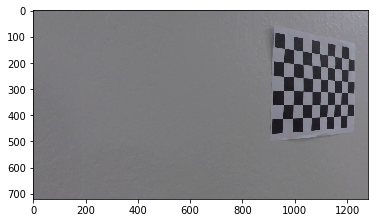

In [12]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[1]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

In [17]:
def to_grayscale(img):
    """
    Returns the grayscaled version of the supplied image (in RGB format)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [13]:
cx = 9
cy = 6

In [14]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)

In [15]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

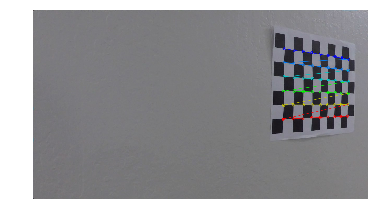

In [18]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

### Image Undistortion

In [19]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [20]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix


In [21]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

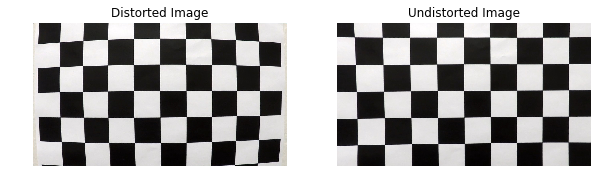

In [24]:
cal_img_example = load_image(cal_imgs_paths[11])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

### Undistort all test images

In [25]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [26]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [27]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [28]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

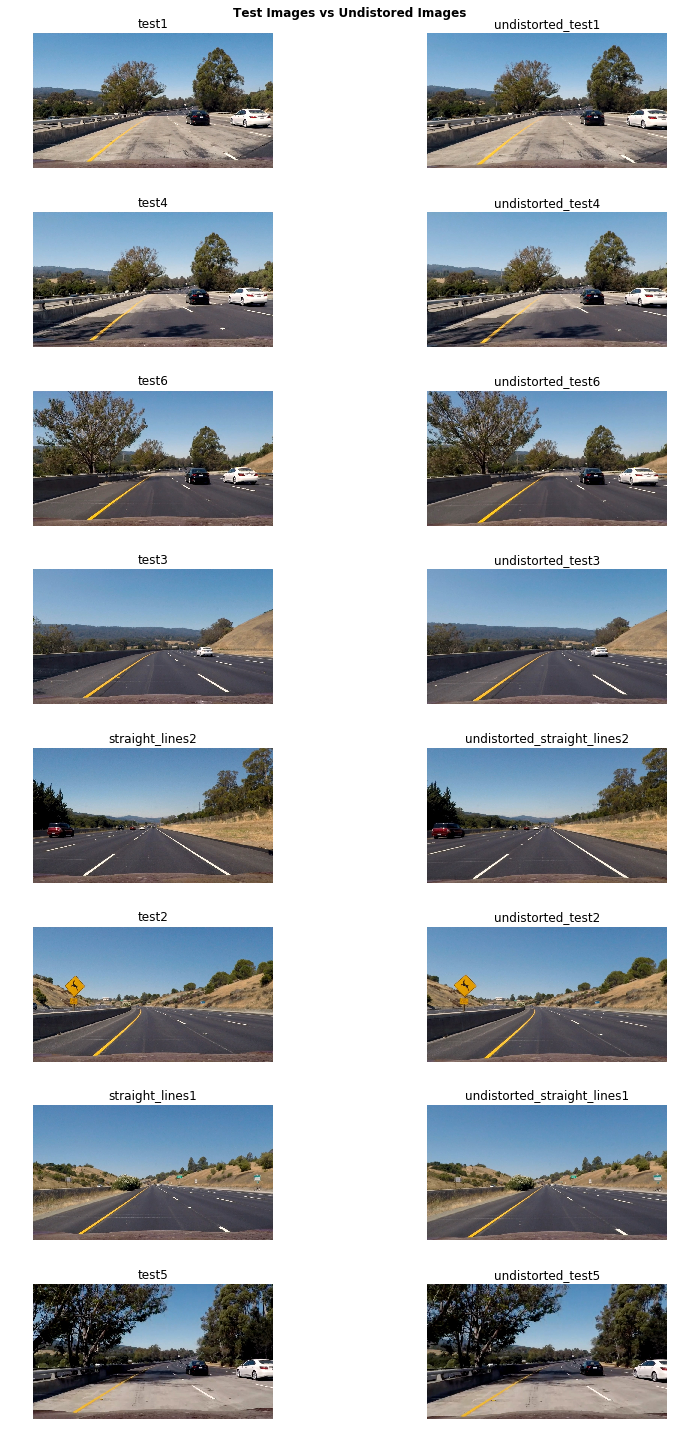

In [29]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

## Color and Edge Thresholding

In [30]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [31]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding


In [32]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [34]:
def to_hls(img):
    """
    Returns the same image in HLS format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [35]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [36]:
def to_hsv(img):
    """
    Returns the same image in HSV format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [37]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [38]:
def to_lab(img):
    """
    Returns the same image in LAB format
    Th input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2LAB  )

In [39]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [40]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

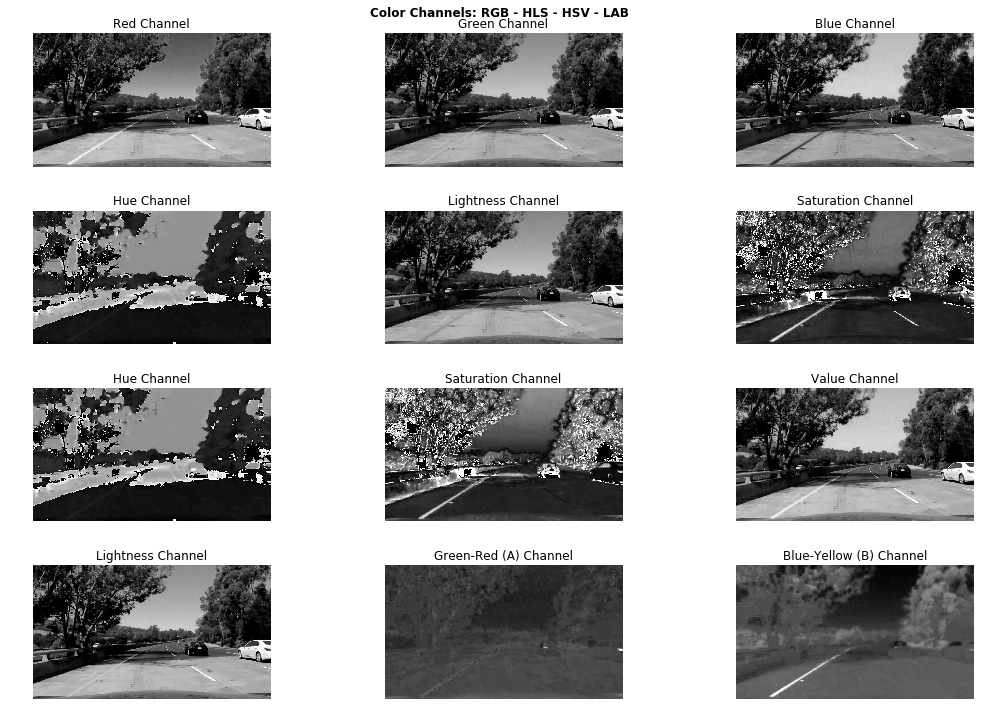

In [41]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

In [42]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

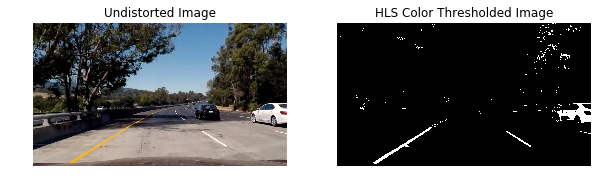

In [43]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

### Gradient Thresholding Via Sobel

In [44]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [45]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [46]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

In [47]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

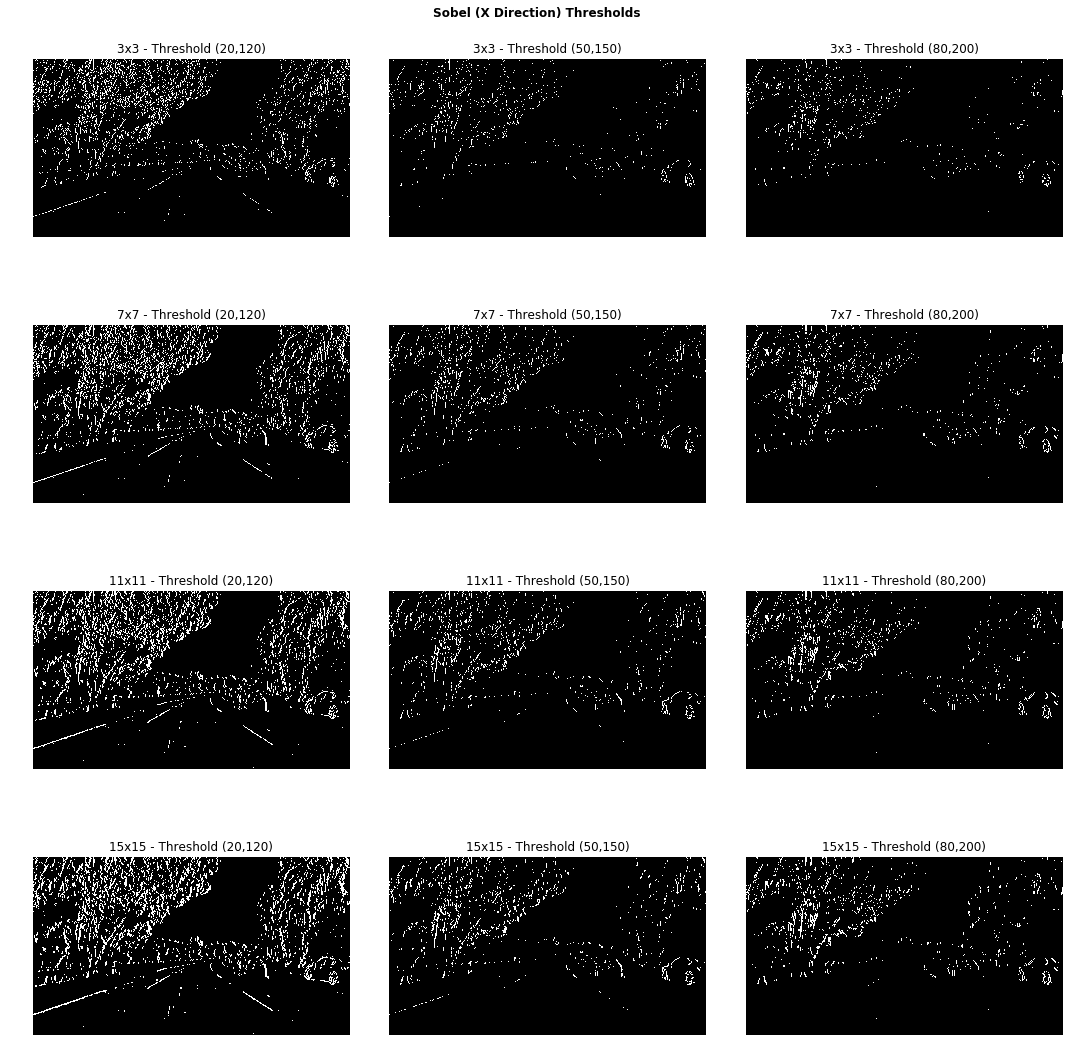

In [48]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [50]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [51]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

In [52]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

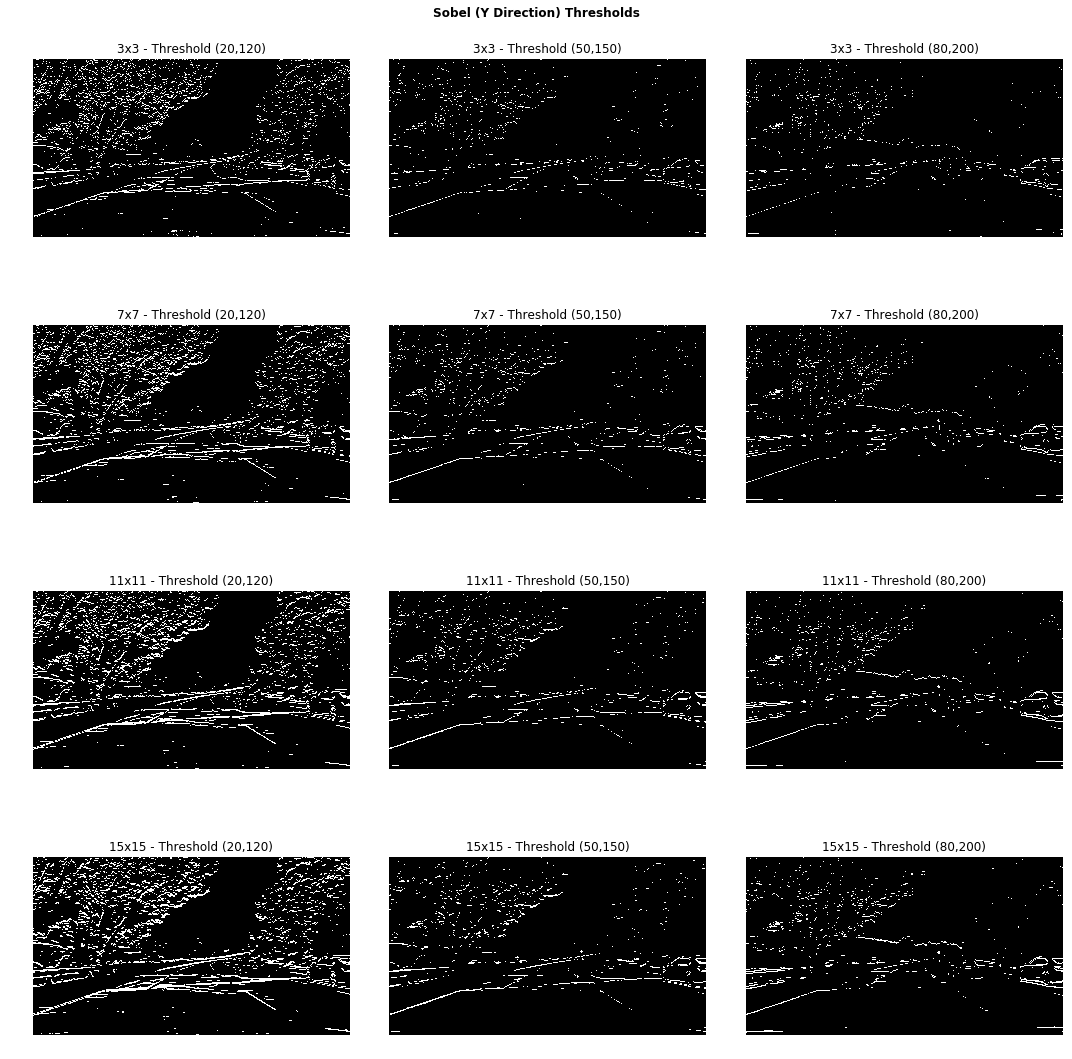

In [53]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [54]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions


In [55]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [56]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])

In [57]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))

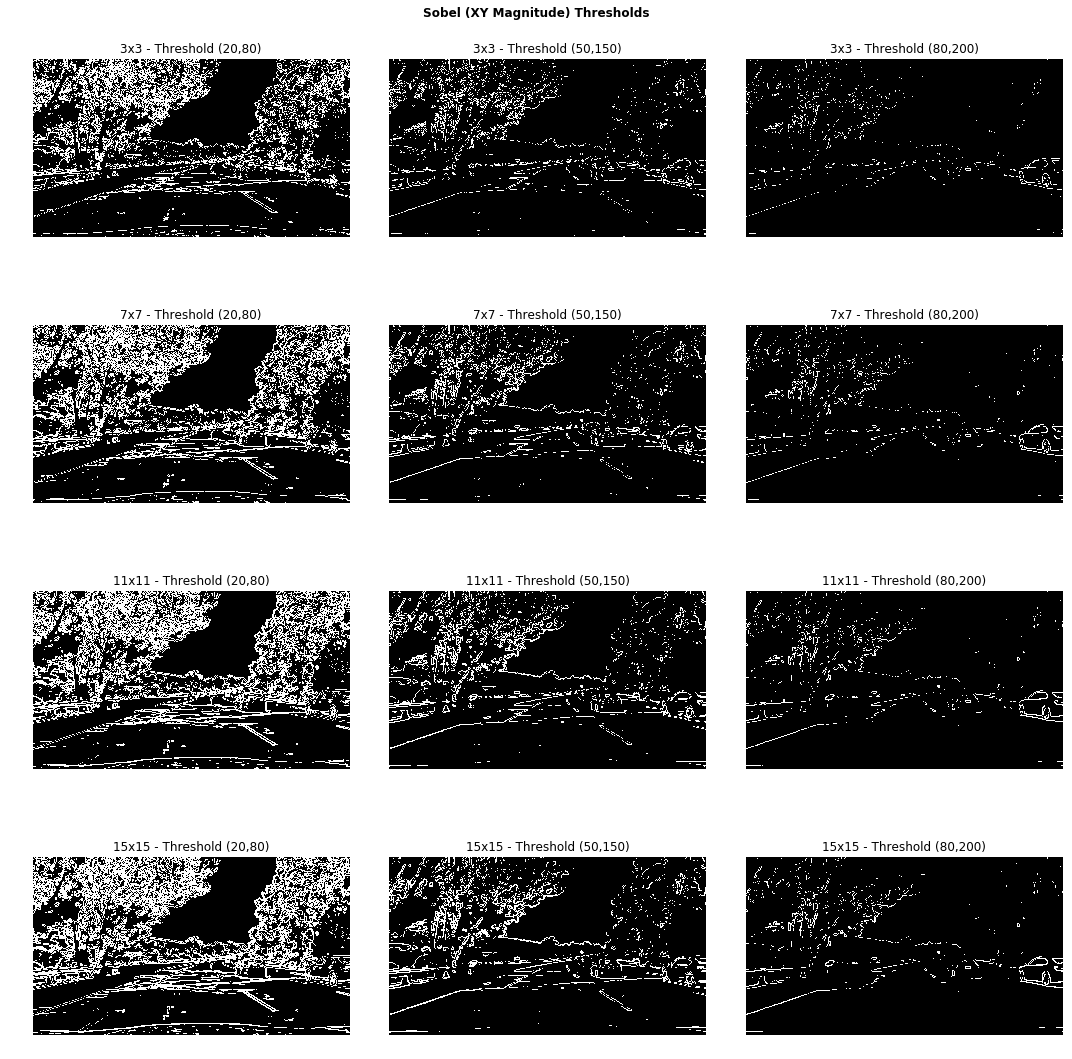

In [58]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[80, 200]_ and kernel size 15.

In [59]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction


In [60]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [61]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [62]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [63]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [64]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

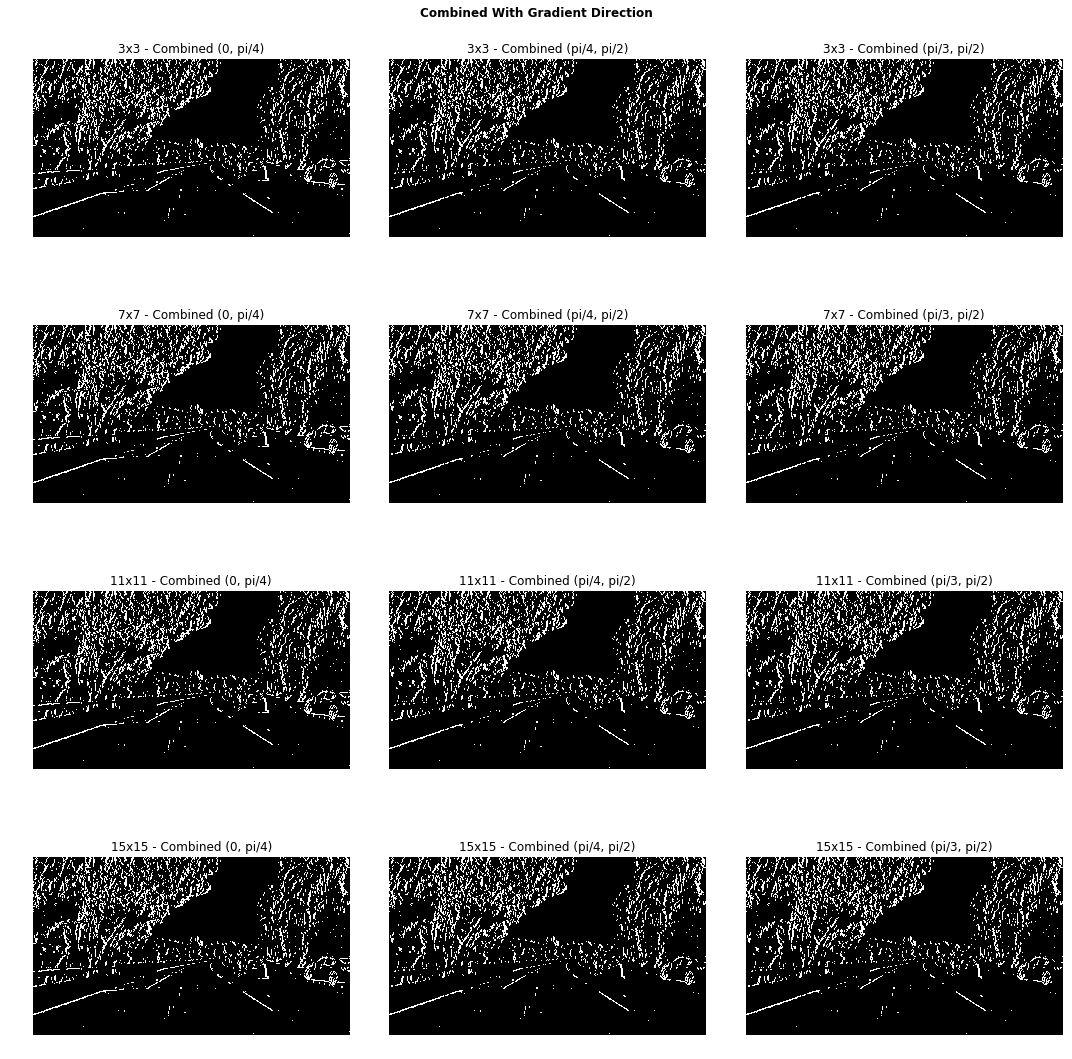

In [65]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

I am inclined to elect interval _[pi/4, pi/2]_ as our best configuration. Kernel size of 15x15 produces the least noise.

In [66]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

### Combining Color And Gradient (Sobel) Thresholds

In [69]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [70]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [71]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

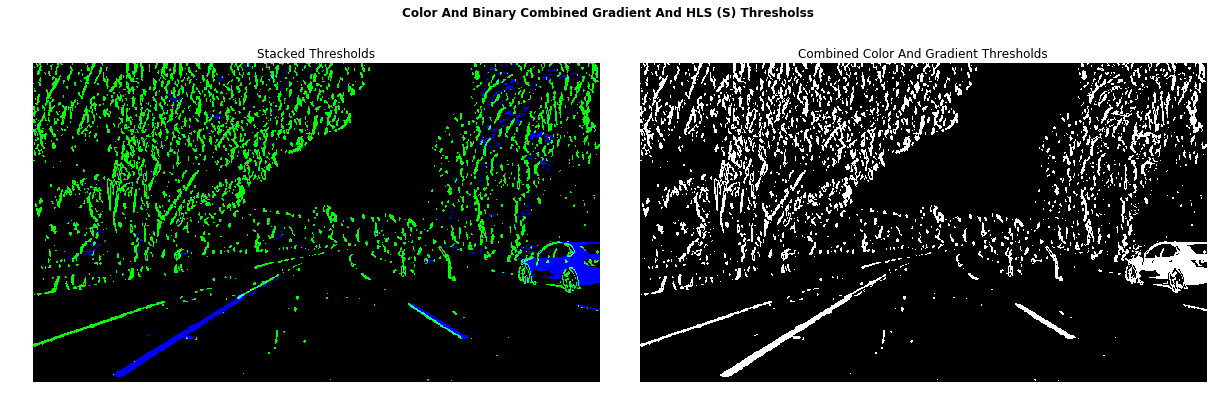

In [72]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

## Perspective Transform

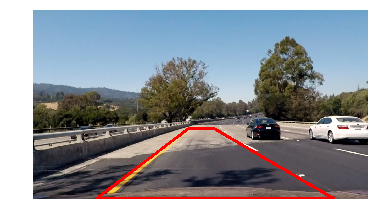

In [76]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[240,bottom_px],[595,450],[690,450], [1150, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [77]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [78]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [79]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [80]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

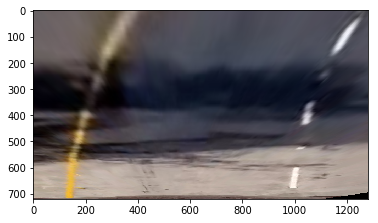

In [81]:
plt.imshow(test_img_persp_tr)

In [82]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

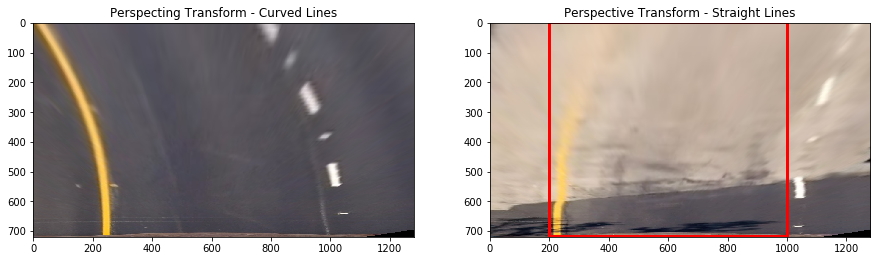

In [83]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

In [84]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

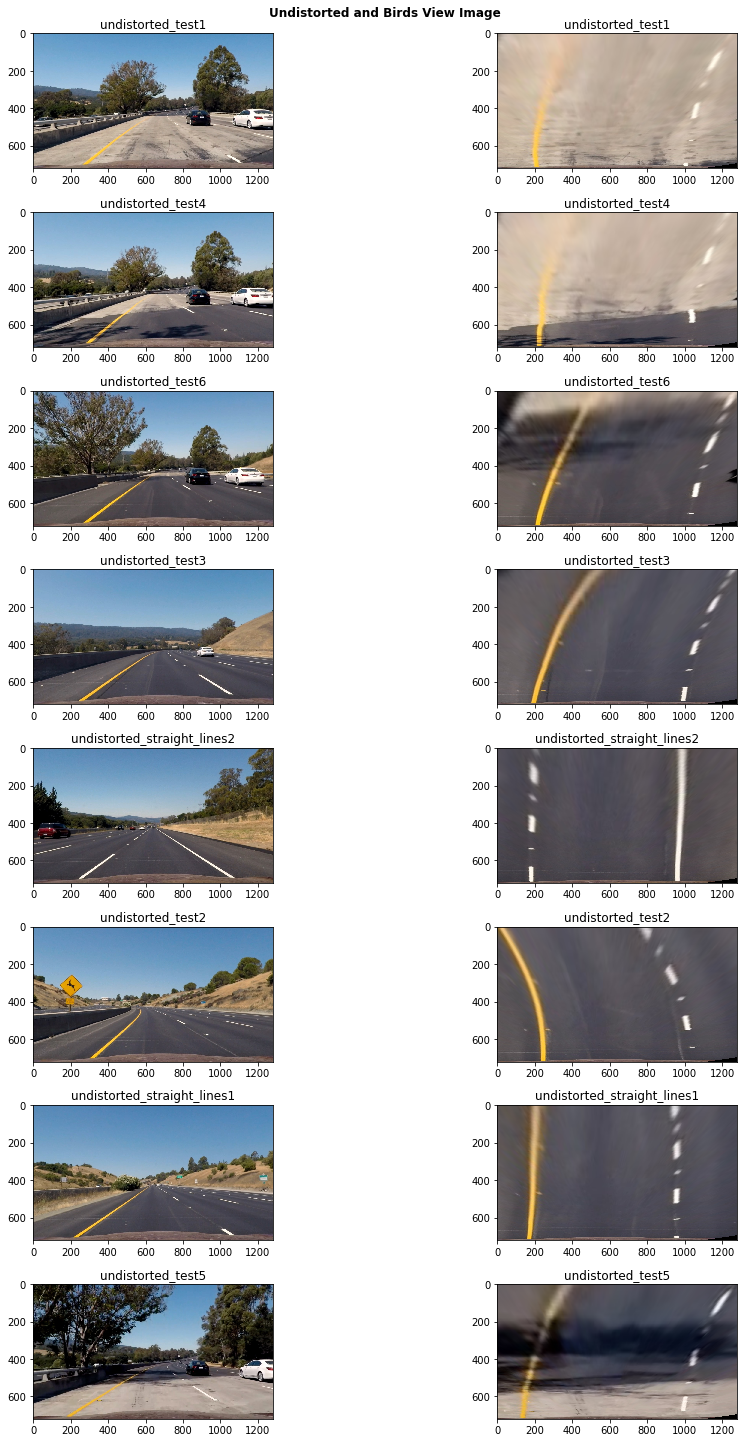

In [85]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

### Putting It All Together

In [86]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [87]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [88]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [89]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [90]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

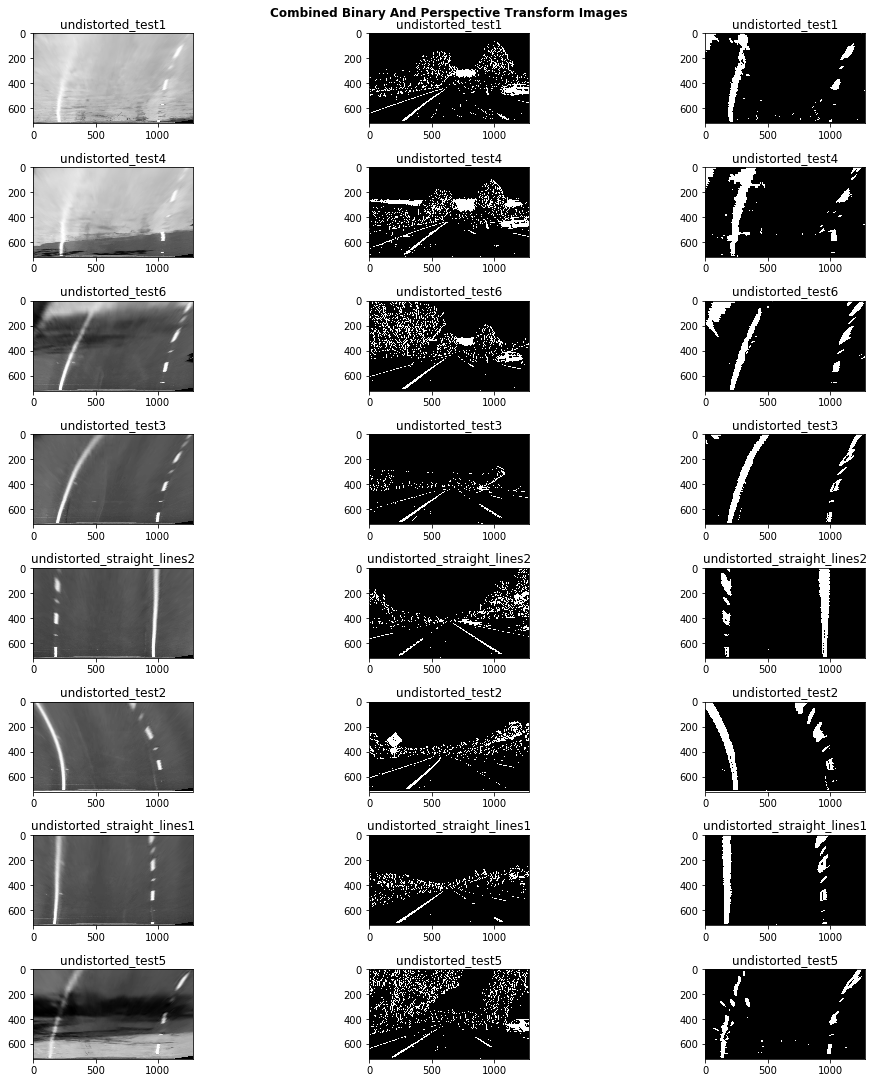

In [91]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

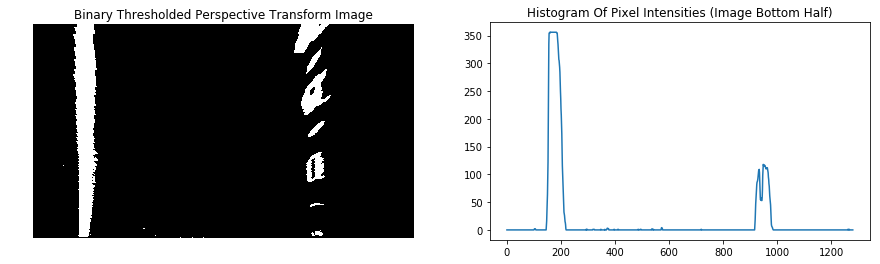

In [92]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Pipeline Definition

In [93]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [94]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [95]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [96]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [97]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [98]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19339.091200037932
Left Curvature   Right Curvature  Center Alignment 
519.7392m        340.6895m        0.1311m Left     


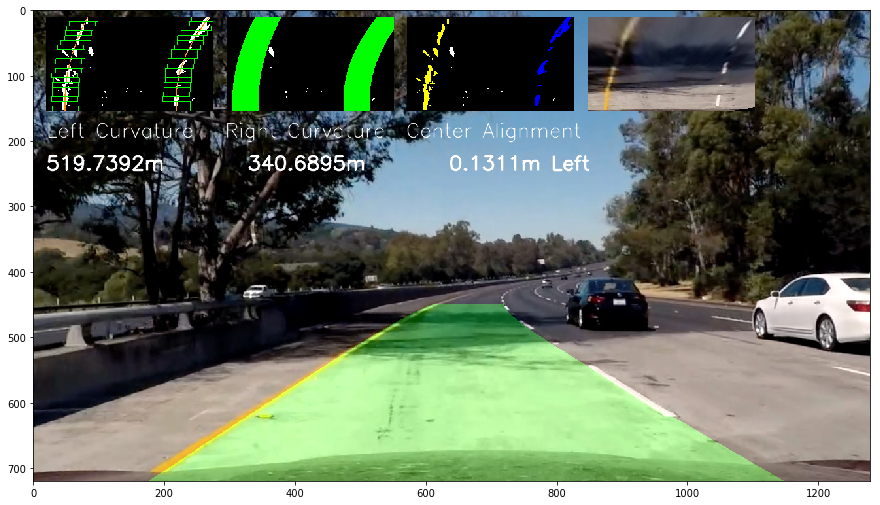

In [99]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

# Normal video

In [100]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [101]:
project_video_path = "project_video.mp4"
challenge_video_path = "challenge_video.mp4"
project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_sample_path = 'challenge_video_sample.mp4'

project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

In [102]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /home/anvith/.imageio/ffmpeg/ffmpeg.linux64 -y -i project_video.mp4 -ss 22.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [104]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14716.660064818148
Left Curvature   Right Curvature  Center Alignment 
1322.1331m       3455.7601m       0.0459m Left     
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4


  1%|          | 1/125 [00:01<03:35,  1.74s/it]

[Previous lane] Found pct=0.9165766414596087
Left Curvature   Right Curvature  Center Alignment 
1328.9832m       3561.7511m       0.0412m Left     


  2%|▏         | 2/125 [00:03<03:33,  1.73s/it]

[Previous lane] Found pct=0.9166966750690193
Left Curvature   Right Curvature  Center Alignment 
1329.2906m       3580.0571m       0.0406m Left     


  2%|▏         | 3/125 [00:05<03:30,  1.72s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  3%|▎         | 4/125 [00:06<03:29,  1.73s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  4%|▍         | 5/125 [00:08<03:29,  1.75s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  5%|▍         | 6/125 [00:10<03:26,  1.73s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  6%|▌         | 7/125 [00:12<03:23,  1.73s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  6%|▋         | 8/125 [00:13<03:20,  1.72s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  7%|▋         | 9/125 [00:15<03:18,  1.71s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  8%|▊         | 10/125 [00:17<03:16,  1.71s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


  9%|▉         | 11/125 [00:18<03:14,  1.70s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 10%|▉         | 12/125 [00:20<03:12,  1.70s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 10%|█         | 13/125 [00:22<03:10,  1.71s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 11%|█         | 14/125 [00:23<03:08,  1.70s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 12%|█▏        | 15/125 [00:25<03:07,  1.70s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 13%|█▎        | 16/125 [00:27<03:08,  1.73s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 14%|█▎        | 17/125 [00:29<03:07,  1.74s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 14%|█▍        | 18/125 [00:30<03:06,  1.74s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 15%|█▌        | 19/125 [00:32<03:10,  1.80s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 16%|█▌        | 20/125 [00:34<03:08,  1.80s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 17%|█▋        | 21/125 [00:36<03:06,  1.79s/it]

[Previous lane] Found pct=0.9166666666666666
Left Curvature   Right Curvature  Center Alignment 
1329.0052m       3580.0571m       0.0406m Left     


 18%|█▊        | 22/125 [00:38<03:04,  1.79s/it]

[Previous lane] Found pct=0.8908506758516889
Left Curvature   Right Curvature  Center Alignment 
1145.4731m       3119.2496m       0.0414m Left     


 18%|█▊        | 23/125 [00:39<02:59,  1.76s/it]

[Previous lane] Found pct=0.8999295485234545
Left Curvature   Right Curvature  Center Alignment 
1157.4816m       3254.2308m       0.0390m Left     


 19%|█▉        | 24/125 [00:41<02:55,  1.74s/it]

[Previous lane] Found pct=0.8896564777136368
Left Curvature   Right Curvature  Center Alignment 
1004.9369m       3462.6367m       0.0293m Left     


 20%|██        | 25/125 [00:43<02:52,  1.72s/it]

[Previous lane] Found pct=0.8755952992770754
Left Curvature   Right Curvature  Center Alignment 
816.6689m        4185.0725m       0.0256m Left     


 21%|██        | 26/125 [00:45<02:51,  1.73s/it]

[Previous lane] Found pct=0.8679936093729197
Left Curvature   Right Curvature  Center Alignment 
833.7668m        2638.9216m       0.0110m Left     


 22%|██▏       | 27/125 [00:46<02:49,  1.73s/it]

[Previous lane] Found pct=0.9036031506619742
Left Curvature   Right Curvature  Center Alignment 
1266.6284m       2787.6230m       0.0368m Right    


 22%|██▏       | 28/125 [00:48<02:46,  1.72s/it]

[Previous lane] Found pct=0.9043089782389393
Left Curvature   Right Curvature  Center Alignment 
1401.7257m       973.8935m        0.0642m Right    


 23%|██▎       | 29/125 [00:50<02:44,  1.71s/it]

[Previous lane] Found pct=0.9103616674923916
Left Curvature   Right Curvature  Center Alignment 
1727.9261m       783.8911m        0.0671m Right    


 24%|██▍       | 30/125 [00:51<02:41,  1.71s/it]

[Previous lane] Found pct=0.9016581999424902
Left Curvature   Right Curvature  Center Alignment 
2624.7673m       841.8218m        0.0674m Right    


 25%|██▍       | 31/125 [00:53<02:40,  1.71s/it]

[Previous lane] Found pct=0.921722238145282
Left Curvature   Right Curvature  Center Alignment 
3462.6076m       748.0764m        0.0754m Right    


 26%|██▌       | 32/125 [00:55<02:38,  1.70s/it]

[Previous lane] Found pct=0.9078969694912954
Left Curvature   Right Curvature  Center Alignment 
1827.9094m       840.3317m        0.0498m Right    


 26%|██▋       | 33/125 [00:57<02:36,  1.70s/it]

[Previous lane] Found pct=0.9102721088435374
Left Curvature   Right Curvature  Center Alignment 
1048.7671m       844.4817m        0.0211m Right    


 27%|██▋       | 34/125 [00:58<02:34,  1.69s/it]

[Previous lane] Found pct=0.9220653429199419
Left Curvature   Right Curvature  Center Alignment 
638.1499m        837.1454m        0.0069m Left     


 28%|██▊       | 35/125 [01:00<02:32,  1.69s/it]

[Previous lane] Found pct=0.9155802749043503
Left Curvature   Right Curvature  Center Alignment 
748.1233m        809.0202m        0.0137m Left     


 29%|██▉       | 36/125 [01:02<02:30,  1.69s/it]

[Previous lane] Found pct=0.9135597595604233
Left Curvature   Right Curvature  Center Alignment 
706.2880m        763.9168m        0.0056m Left     


 30%|██▉       | 37/125 [01:03<02:29,  1.70s/it]

[Previous lane] Found pct=0.9187484229119354
Left Curvature   Right Curvature  Center Alignment 
580.7616m        691.9661m        0.0165m Left     


 30%|███       | 38/125 [01:05<02:28,  1.71s/it]

[Previous lane] Found pct=0.9041698841698842
Left Curvature   Right Curvature  Center Alignment 
487.3698m        927.7421m        0.0263m Left     


 31%|███       | 39/125 [01:07<02:28,  1.72s/it]

[Previous lane] Found pct=0.9038955069521585
Left Curvature   Right Curvature  Center Alignment 
559.3334m        1749.8876m       0.0431m Left     


 32%|███▏      | 40/125 [01:09<02:28,  1.75s/it]

[Previous lane] Found pct=0.9148840012051823
Left Curvature   Right Curvature  Center Alignment 
620.8430m        426.5155m        0.0262m Right    


 33%|███▎      | 41/125 [01:10<02:25,  1.73s/it]

[Previous lane] Found pct=0.9091286934179702
Left Curvature   Right Curvature  Center Alignment 
499.4950m        396.0284m        0.0081m Right    


 34%|███▎      | 42/125 [01:12<02:22,  1.72s/it]

[Previous lane] Found pct=0.8762376237623762
Left Curvature   Right Curvature  Center Alignment 
430.1871m        346.0258m        0.0059m Left     


 34%|███▍      | 43/125 [01:14<02:20,  1.72s/it]

[Previous lane] Found pct=0.8322960902035437
Non zeros found below thresholds, begining sliding window - pct=0.8322960902035437
[Sliding windows] Found pct=11564.960023429492
Left Curvature   Right Curvature  Center Alignment 
408.5310m        6359.1554m       0.1001m Left     


 35%|███▌      | 44/125 [01:15<02:18,  1.71s/it]

[Previous lane] Found pct=0.8424097779706372
Non zeros found below thresholds, begining sliding window - pct=0.8424097779706372
[Sliding windows] Found pct=11984.334598973024
Left Curvature   Right Curvature  Center Alignment 
369.2660m        5531.0080m       0.1045m Left     


 36%|███▌      | 45/125 [01:17<02:16,  1.71s/it]

[Previous lane] Found pct=0.8119108512970405
Non zeros found below thresholds, begining sliding window - pct=0.8119108512970405
[Sliding windows] Found pct=12145.760686883448
Left Curvature   Right Curvature  Center Alignment 
2489.1224m       3698.9448m       0.0895m Left     


 37%|███▋      | 46/125 [01:19<02:14,  1.71s/it]

[Previous lane] Found pct=0.8761204320845782
Left Curvature   Right Curvature  Center Alignment 
2595.6006m       2654.0634m       0.0859m Left     


 38%|███▊      | 47/125 [01:20<02:13,  1.71s/it]

[Previous lane] Found pct=0.8955452170033777
Left Curvature   Right Curvature  Center Alignment 
4127.1342m       1980.2877m       0.0781m Left     


 38%|███▊      | 48/125 [01:22<02:11,  1.71s/it]

[Previous lane] Found pct=0.8845283701849115
Left Curvature   Right Curvature  Center Alignment 
3615.5523m       1502.9910m       0.0836m Left     


 39%|███▉      | 49/125 [01:24<02:09,  1.70s/it]

[Previous lane] Found pct=0.8614644868800659
Left Curvature   Right Curvature  Center Alignment 
3667.9753m       971.2464m        0.0779m Left     


 40%|████      | 50/125 [01:26<02:07,  1.70s/it]

[Previous lane] Found pct=0.9055778775703144
Left Curvature   Right Curvature  Center Alignment 
5780.0550m       613.4949m        0.0422m Left     


 41%|████      | 51/125 [01:27<02:05,  1.70s/it]

[Previous lane] Found pct=0.8649793583551442
Left Curvature   Right Curvature  Center Alignment 
3494.0141m       515.0897m        0.0115m Left     


 42%|████▏     | 52/125 [01:29<02:05,  1.72s/it]

[Previous lane] Found pct=0.9045701519706539
Left Curvature   Right Curvature  Center Alignment 
5308.1859m       460.3001m        0.0078m Right    


 42%|████▏     | 53/125 [01:31<02:03,  1.71s/it]

[Previous lane] Found pct=0.9017982975365015
Left Curvature   Right Curvature  Center Alignment 
11453.4859m      431.9800m        0.0033m Right    


 43%|████▎     | 54/125 [01:32<02:01,  1.71s/it]

[Previous lane] Found pct=0.9009109753436614
Left Curvature   Right Curvature  Center Alignment 
1377.9136m       367.0009m        0.0165m Right    


 44%|████▍     | 55/125 [01:34<01:59,  1.71s/it]

[Previous lane] Found pct=0.8494010899333315
Non zeros found below thresholds, begining sliding window - pct=0.8494010899333315
[Sliding windows] Found pct=16380.965033610888
Left Curvature   Right Curvature  Center Alignment 
682.2691m        531.5130m        0.0301m Left     


 45%|████▍     | 56/125 [01:36<01:57,  1.71s/it]

[Previous lane] Found pct=0.9184950362893134
Left Curvature   Right Curvature  Center Alignment 
608.4304m        450.5672m        0.0450m Left     


 46%|████▌     | 57/125 [01:38<01:56,  1.71s/it]

[Previous lane] Found pct=0.9549534435030618
Left Curvature   Right Curvature  Center Alignment 
525.8958m        391.7856m        0.0597m Left     


 46%|████▋     | 58/125 [01:39<01:54,  1.71s/it]

[Previous lane] Found pct=0.9218806791629888
Left Curvature   Right Curvature  Center Alignment 
525.8647m        427.7958m        0.0821m Left     


 47%|████▋     | 59/125 [01:41<01:52,  1.71s/it]

[Previous lane] Found pct=0.9206074731223216
Left Curvature   Right Curvature  Center Alignment 
532.0983m        425.5419m        0.0985m Left     


 48%|████▊     | 60/125 [01:43<01:50,  1.71s/it]

[Previous lane] Found pct=0.9212247324613555
Left Curvature   Right Curvature  Center Alignment 
518.7860m        422.0961m        0.1117m Left     


 49%|████▉     | 61/125 [01:44<01:49,  1.71s/it]

[Previous lane] Found pct=0.9230225816667073
Left Curvature   Right Curvature  Center Alignment 
520.7363m        444.1497m        0.1322m Left     


 50%|████▉     | 62/125 [01:46<01:47,  1.70s/it]

[Previous lane] Found pct=0.909506901380276
Left Curvature   Right Curvature  Center Alignment 
411.2659m        542.2100m        0.1596m Left     


 50%|█████     | 63/125 [01:48<01:45,  1.70s/it]

[Previous lane] Found pct=0.9131642850471654
Left Curvature   Right Curvature  Center Alignment 
341.0022m        771.3398m        0.2124m Left     


 51%|█████     | 64/125 [01:50<01:44,  1.71s/it]

[Previous lane] Found pct=0.9278191985088536
Left Curvature   Right Curvature  Center Alignment 
329.3144m        786.7878m        0.2298m Left     


 52%|█████▏    | 65/125 [01:51<01:42,  1.71s/it]

[Previous lane] Found pct=0.9326744764575512
Left Curvature   Right Curvature  Center Alignment 
333.2822m        871.6097m        0.2391m Left     


 53%|█████▎    | 66/125 [01:53<01:40,  1.71s/it]

[Previous lane] Found pct=0.9326950277445327
Left Curvature   Right Curvature  Center Alignment 
335.2222m        668.4503m        0.2325m Left     


 54%|█████▎    | 67/125 [01:55<01:40,  1.74s/it]

[Previous lane] Found pct=0.9191902327037462
Left Curvature   Right Curvature  Center Alignment 
325.8154m        528.1360m        0.2224m Left     


 54%|█████▍    | 68/125 [01:56<01:38,  1.73s/it]

[Previous lane] Found pct=0.9427270962314214
Left Curvature   Right Curvature  Center Alignment 
330.6520m        533.0556m        0.2259m Left     


 55%|█████▌    | 69/125 [01:58<01:36,  1.73s/it]

[Previous lane] Found pct=0.9042104099900542
Left Curvature   Right Curvature  Center Alignment 
328.5821m        472.0208m        0.2271m Left     


 56%|█████▌    | 70/125 [02:00<01:34,  1.72s/it]

[Previous lane] Found pct=0.9516333028043089
Left Curvature   Right Curvature  Center Alignment 
320.8636m        488.4939m        0.2256m Left     


 57%|█████▋    | 71/125 [02:02<01:32,  1.71s/it]

[Previous lane] Found pct=0.9556913348145616
Left Curvature   Right Curvature  Center Alignment 
322.1059m        459.8944m        0.2255m Left     


 58%|█████▊    | 72/125 [02:03<01:30,  1.71s/it]

[Previous lane] Found pct=0.9741501416430595
Left Curvature   Right Curvature  Center Alignment 
347.3466m        537.6050m        0.2293m Left     


 58%|█████▊    | 73/125 [02:05<01:29,  1.71s/it]

[Previous lane] Found pct=0.9663037953236191
Left Curvature   Right Curvature  Center Alignment 
364.8695m        571.0622m        0.2200m Left     


 59%|█████▉    | 74/125 [02:07<01:27,  1.72s/it]

[Previous lane] Found pct=0.9677286318177132
Left Curvature   Right Curvature  Center Alignment 
373.4559m        608.8164m        0.2184m Left     


 60%|██████    | 75/125 [02:08<01:25,  1.72s/it]

[Previous lane] Found pct=0.7393728363255776
Non zeros found below thresholds, begining sliding window - pct=0.7393728363255776
[Sliding windows] Found pct=22903.218983978746
Left Curvature   Right Curvature  Center Alignment 
319.6067m        429.0625m        0.1864m Left     


 61%|██████    | 76/125 [02:10<01:24,  1.72s/it]

[Previous lane] Found pct=0.8639918261484655
Left Curvature   Right Curvature  Center Alignment 
322.1605m        427.6268m        0.1728m Left     


 62%|██████▏   | 77/125 [02:12<01:22,  1.71s/it]

[Previous lane] Found pct=0.8840410683899586
Left Curvature   Right Curvature  Center Alignment 
320.2559m        413.9806m        0.1632m Left     


 62%|██████▏   | 78/125 [02:14<01:20,  1.72s/it]

[Previous lane] Found pct=0.8497814584771106
Non zeros found below thresholds, begining sliding window - pct=0.8497814584771106
[Sliding windows] Found pct=22876.152538148915
Left Curvature   Right Curvature  Center Alignment 
340.3454m        333.5704m        0.1254m Left     


 63%|██████▎   | 79/125 [02:15<01:18,  1.72s/it]

[Previous lane] Found pct=0.825568644097775
Non zeros found below thresholds, begining sliding window - pct=0.825568644097775
[Sliding windows] Found pct=24878.664208143196
Left Curvature   Right Curvature  Center Alignment 
382.9951m        322.6853m        0.0894m Left     


 64%|██████▍   | 80/125 [02:17<01:17,  1.72s/it]

[Previous lane] Found pct=0.7978672302814872
Non zeros found below thresholds, begining sliding window - pct=0.7978672302814872
[Sliding windows] Found pct=24698.27923911999
Left Curvature   Right Curvature  Center Alignment 
468.9863m        427.8349m        0.1055m Left     


 65%|██████▍   | 81/125 [02:19<01:15,  1.72s/it]

[Previous lane] Found pct=0.9000331870644198
Left Curvature   Right Curvature  Center Alignment 
524.2816m        595.9561m        0.1400m Left     


 66%|██████▌   | 82/125 [02:20<01:13,  1.72s/it]

[Previous lane] Found pct=0.9219802342606149
Left Curvature   Right Curvature  Center Alignment 
551.7549m        784.9968m        0.1547m Left     


 66%|██████▋   | 83/125 [02:22<01:12,  1.72s/it]

[Previous lane] Found pct=0.9861754540775057
Left Curvature   Right Curvature  Center Alignment 
668.4483m        796.2891m        0.1654m Left     


 67%|██████▋   | 84/125 [02:24<01:10,  1.72s/it]

[Previous lane] Found pct=0.9661543376402102
Left Curvature   Right Curvature  Center Alignment 
625.8269m        483.3783m        0.1386m Left     


 68%|██████▊   | 85/125 [02:26<01:08,  1.71s/it]

[Previous lane] Found pct=0.8718809048687022
Left Curvature   Right Curvature  Center Alignment 
731.0157m        464.2857m        0.1557m Left     


 69%|██████▉   | 86/125 [02:27<01:07,  1.72s/it]

[Previous lane] Found pct=0.7723244951229564
Non zeros found below thresholds, begining sliding window - pct=0.7723244951229564
[Sliding windows] Found pct=26346.891142327244
Left Curvature   Right Curvature  Center Alignment 
546.5604m        382.1151m        0.1258m Left     


 70%|██████▉   | 87/125 [02:29<01:05,  1.72s/it]

[Previous lane] Found pct=0.7960022209883398
Non zeros found below thresholds, begining sliding window - pct=0.7960022209883398
[Sliding windows] Found pct=24170.11186377938
Left Curvature   Right Curvature  Center Alignment 
490.0373m        315.2977m        0.1101m Left     


 70%|███████   | 88/125 [02:31<01:03,  1.72s/it]

[Previous lane] Found pct=0.8913086094131485
Left Curvature   Right Curvature  Center Alignment 
575.7318m        326.7663m        0.1131m Left     


 71%|███████   | 89/125 [02:32<01:01,  1.72s/it]

[Previous lane] Found pct=0.9271802039097636
Left Curvature   Right Curvature  Center Alignment 
595.3118m        350.1570m        0.1004m Left     


 72%|███████▏  | 90/125 [02:34<01:00,  1.72s/it]

[Previous lane] Found pct=0.8715881221659579
Left Curvature   Right Curvature  Center Alignment 
625.1451m        412.1983m        0.0917m Left     


 73%|███████▎  | 91/125 [02:36<00:58,  1.72s/it]

[Previous lane] Found pct=0.8037217320758544
Non zeros found below thresholds, begining sliding window - pct=0.8037217320758544
[Sliding windows] Found pct=27321.762600141974
Left Curvature   Right Curvature  Center Alignment 
1097.3462m       553.0427m        0.0907m Left     


 74%|███████▎  | 92/125 [02:38<00:56,  1.72s/it]

[Previous lane] Found pct=0.9897131486197069
Left Curvature   Right Curvature  Center Alignment 
1314.1572m       771.5847m        0.1195m Left     


 74%|███████▍  | 93/125 [02:39<00:54,  1.72s/it]

[Previous lane] Found pct=0.9830783922797259
Left Curvature   Right Curvature  Center Alignment 
1221.0101m       576.5389m        0.0837m Left     


 75%|███████▌  | 94/125 [02:41<00:53,  1.72s/it]

[Previous lane] Found pct=0.9677065561784061
Left Curvature   Right Curvature  Center Alignment 
1049.0738m       457.2960m        0.0572m Left     


 76%|███████▌  | 95/125 [02:43<00:51,  1.72s/it]

[Previous lane] Found pct=0.9862741402059736
Left Curvature   Right Curvature  Center Alignment 
836.0608m        443.6607m        0.0418m Left     


 77%|███████▋  | 96/125 [02:45<00:50,  1.75s/it]

[Previous lane] Found pct=0.9746955726050538
Left Curvature   Right Curvature  Center Alignment 
690.7768m        471.5022m        0.0390m Left     


 78%|███████▊  | 97/125 [02:46<00:48,  1.73s/it]

[Previous lane] Found pct=0.9845723770420197
Left Curvature   Right Curvature  Center Alignment 
630.7847m        514.4596m        0.0386m Left     


 78%|███████▊  | 98/125 [02:48<00:46,  1.73s/it]

[Previous lane] Found pct=0.9848857045377004
Left Curvature   Right Curvature  Center Alignment 
657.3235m        523.3728m        0.0346m Left     


 79%|███████▉  | 99/125 [02:50<00:44,  1.72s/it]

[Previous lane] Found pct=0.9511661927382107
Left Curvature   Right Curvature  Center Alignment 
640.8281m        536.9781m        0.0321m Left     


 80%|████████  | 100/125 [02:51<00:43,  1.72s/it]

[Previous lane] Found pct=0.9481800766283525
Left Curvature   Right Curvature  Center Alignment 
632.7417m        596.6355m        0.0285m Left     


 81%|████████  | 101/125 [02:53<00:41,  1.73s/it]

[Previous lane] Found pct=0.9296504369538078
Left Curvature   Right Curvature  Center Alignment 
606.4268m        556.3607m        0.0188m Left     


 82%|████████▏ | 102/125 [02:55<00:39,  1.72s/it]

[Previous lane] Found pct=0.9043313514679153
Left Curvature   Right Curvature  Center Alignment 
587.2339m        555.7082m        0.0156m Left     


 82%|████████▏ | 103/125 [02:57<00:37,  1.72s/it]

[Previous lane] Found pct=0.8873230816310917
Left Curvature   Right Curvature  Center Alignment 
540.4720m        527.5994m        0.0090m Left     


 83%|████████▎ | 104/125 [02:58<00:36,  1.72s/it]

[Previous lane] Found pct=0.8663808124119331
Left Curvature   Right Curvature  Center Alignment 
528.7673m        533.2904m        0.0075m Left     


 84%|████████▍ | 105/125 [03:00<00:34,  1.72s/it]

[Previous lane] Found pct=0.8267219205487282
Non zeros found below thresholds, begining sliding window - pct=0.8267219205487282
[Sliding windows] Found pct=30878.906816233208
Left Curvature   Right Curvature  Center Alignment 
481.4784m        521.6966m        0.0277m Right    


 85%|████████▍ | 106/125 [03:02<00:32,  1.73s/it]

[Previous lane] Found pct=0.8366107160337432
Non zeros found below thresholds, begining sliding window - pct=0.8366107160337432
[Sliding windows] Found pct=31392.55787003714
Left Curvature   Right Curvature  Center Alignment 
522.8546m        542.4446m        0.0172m Right    


 86%|████████▌ | 107/125 [03:04<00:31,  1.73s/it]

[Previous lane] Found pct=0.8281687353332013
Non zeros found below thresholds, begining sliding window - pct=0.8281687353332013
[Sliding windows] Found pct=31620.69208911759
Left Curvature   Right Curvature  Center Alignment 
510.4922m        556.2849m        0.0208m Right    


 86%|████████▋ | 108/125 [03:05<00:29,  1.73s/it]

[Previous lane] Found pct=0.7917561365837228
Non zeros found below thresholds, begining sliding window - pct=0.7917561365837228
[Sliding windows] Found pct=31617.302653923343
Left Curvature   Right Curvature  Center Alignment 
472.5900m        574.0175m        0.0170m Right    


 87%|████████▋ | 109/125 [03:07<00:27,  1.72s/it]

[Previous lane] Found pct=0.8402428902188633
Non zeros found below thresholds, begining sliding window - pct=0.8402428902188633
[Sliding windows] Found pct=30975.74065498813
Left Curvature   Right Curvature  Center Alignment 
499.9543m        587.6277m        0.0139m Right    


 88%|████████▊ | 110/125 [03:09<00:25,  1.72s/it]

[Previous lane] Found pct=0.8342604316342064
Non zeros found below thresholds, begining sliding window - pct=0.8342604316342064
[Sliding windows] Found pct=31719.985645388457
Left Curvature   Right Curvature  Center Alignment 
507.5545m        628.3849m        0.0102m Right    


 89%|████████▉ | 111/125 [03:10<00:24,  1.72s/it]

[Previous lane] Found pct=0.8895927738963066
Left Curvature   Right Curvature  Center Alignment 
535.8458m        696.1770m        0.0014m Left     


 90%|████████▉ | 112/125 [03:12<00:22,  1.72s/it]

[Previous lane] Found pct=0.9284815269170106
Left Curvature   Right Curvature  Center Alignment 
549.3239m        744.6593m        0.0007m Left     


 90%|█████████ | 113/125 [03:14<00:20,  1.72s/it]

[Previous lane] Found pct=0.940626603386352
Left Curvature   Right Curvature  Center Alignment 
561.2438m        741.5923m        0.0003m Left     


 91%|█████████ | 114/125 [03:16<00:18,  1.72s/it]

[Previous lane] Found pct=0.9558953346991123
Left Curvature   Right Curvature  Center Alignment 
588.4347m        689.9057m        0.0022m Right    


 92%|█████████▏| 115/125 [03:17<00:17,  1.71s/it]

[Previous lane] Found pct=0.9249203087328683
Left Curvature   Right Curvature  Center Alignment 
577.6670m        583.2140m        0.0139m Right    


 93%|█████████▎| 116/125 [03:19<00:15,  1.71s/it]

[Previous lane] Found pct=0.902888422646748
Left Curvature   Right Curvature  Center Alignment 
609.2098m        478.5805m        0.0277m Right    


 94%|█████████▎| 117/125 [03:21<00:13,  1.71s/it]

[Previous lane] Found pct=0.8794075178163864
Left Curvature   Right Curvature  Center Alignment 
611.8996m        457.3761m        0.0427m Right    


 94%|█████████▍| 118/125 [03:22<00:11,  1.71s/it]

[Previous lane] Found pct=0.9177141938595081
Left Curvature   Right Curvature  Center Alignment 
633.5596m        493.9253m        0.0375m Right    


 95%|█████████▌| 119/125 [03:24<00:10,  1.71s/it]

[Previous lane] Found pct=0.9349589578012305
Left Curvature   Right Curvature  Center Alignment 
695.7398m        495.5486m        0.0389m Right    


 96%|█████████▌| 120/125 [03:26<00:08,  1.72s/it]

[Previous lane] Found pct=0.9527902543057485
Left Curvature   Right Curvature  Center Alignment 
719.8464m        485.7464m        0.0394m Right    


 97%|█████████▋| 121/125 [03:28<00:06,  1.72s/it]

[Previous lane] Found pct=0.9504298133428308
Left Curvature   Right Curvature  Center Alignment 
759.0546m        510.2228m        0.0372m Right    


 98%|█████████▊| 122/125 [03:29<00:05,  1.72s/it]

[Previous lane] Found pct=0.9314315453924471
Left Curvature   Right Curvature  Center Alignment 
775.7644m        560.0400m        0.0243m Right    


 98%|█████████▊| 123/125 [03:31<00:03,  1.72s/it]

[Previous lane] Found pct=0.9470123107582528
Left Curvature   Right Curvature  Center Alignment 
848.5480m        594.0908m        0.0210m Right    


 99%|█████████▉| 124/125 [03:33<00:01,  1.72s/it]

[Previous lane] Found pct=0.9702993609149008
Left Curvature   Right Curvature  Center Alignment 
855.2775m        656.5959m        0.0174m Right    


100%|██████████| 125/125 [03:34<00:00,  1.71s/it]

[Previous lane] Found pct=0.9520512572221684
Left Curvature   Right Curvature  Center Alignment 
850.4955m        630.4657m        0.0218m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 3min 39s, sys: 612 ms, total: 3min 40s
Wall time: 3min 36s


In [105]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

# Challege Videos


In [106]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> /home/anvith/.imageio/ffmpeg/ffmpeg.linux64 -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


In [107]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18178.50359513751
Left Curvature   Right Curvature  Center Alignment 
103.5575m        172.8177m        0.6553m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4


  1%|          | 1/121 [00:01<03:35,  1.80s/it]

[Previous lane] Found pct=0.8612811449262867
Left Curvature   Right Curvature  Center Alignment 
108.7074m        167.7061m        0.7687m Left     


  2%|▏         | 2/121 [00:03<03:34,  1.80s/it]

[Previous lane] Found pct=0.8612710963055127
Left Curvature   Right Curvature  Center Alignment 
104.4810m        165.7824m        0.7483m Left     


  2%|▏         | 3/121 [00:05<03:30,  1.78s/it]

[Previous lane] Found pct=0.8505926321409504
Left Curvature   Right Curvature  Center Alignment 
107.9359m        168.0647m        0.7722m Left     


  3%|▎         | 4/121 [00:07<03:29,  1.79s/it]

[Previous lane] Found pct=0.8423775383162323
Non zeros found below thresholds, begining sliding window - pct=0.8423775383162323
[Sliding windows] Found pct=12458.76293307002
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.28460734  351.77696422   42.18233127 -106.33542918] - y_new=[ 478.98112099  500.76072971  413.90267463  234.34973773] - distance=486.30348635152956 - max-distance=150
**** REVISED Poly left [  2.01346091e-03  -3.15874189e+00   1.11818805e+03]
Left Curvature   Right Curvature  Center Alignment 
106.1791m        168.8660m        0.7587m Left     


  4%|▍         | 5/121 [00:08<03:24,  1.77s/it]

[Previous lane] Found pct=0.8367954324586978
Non zeros found below thresholds, begining sliding window - pct=0.8367954324586978
[Sliding windows] Found pct=13031.125303692907
**** MAX DISTANCE BREACHED ****
y_smooth=[ 966.35153022  353.33560531   42.68478913 -108.17765037] - y_new=[ 470.97649216  508.71950244  422.67130999  233.29636138] - distance=495.3750380629824 - max-distance=150
**** REVISED Poly left [  1.99735471e-03  -3.15113785e+00   1.11891504e+03]
Left Curvature   Right Curvature  Center Alignment 
107.0500m        181.2841m        0.7707m Left     


  5%|▍         | 6/121 [00:10<03:21,  1.75s/it]

[Previous lane] Found pct=0.8352487686487258
Non zeros found below thresholds, begining sliding window - pct=0.8352487686487258
[Sliding windows] Found pct=14647.637572274965
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.81806878  352.55628476   42.4335602  -107.25653978] - y_new=[ 695.9130566   510.47596585  384.57477067  278.62777765] - distance=385.8843174252814 - max-distance=150
**** REVISED Poly left [  2.00540781e-03  -3.15493987e+00   1.11855154e+03]
Left Curvature   Right Curvature  Center Alignment 
106.6127m        330.2119m        0.8050m Left     


  6%|▌         | 7/121 [00:12<03:17,  1.74s/it]

[Previous lane] Found pct=0.8197640220061589
Non zeros found below thresholds, begining sliding window - pct=0.8197640220061589
[Sliding windows] Found pct=15142.839486522958
**** MAX DISTANCE BREACHED ****
y_smooth=[ 966.0847995   352.94594503   42.55917467 -107.71709508] - y_new=[ 738.88822792  519.39368633  384.55732697  285.95143331] - distance=393.6685283848964 - max-distance=150
**** REVISED Poly left [  2.00138126e-03  -3.15303886e+00   1.11873329e+03]
Left Curvature   Right Curvature  Center Alignment 
106.8309m        611.3815m        0.8311m Left     


  7%|▋         | 8/121 [00:13<03:15,  1.73s/it]

[Previous lane] Found pct=0.8216674500162696
Non zeros found below thresholds, begining sliding window - pct=0.8216674500162696
[Sliding windows] Found pct=14637.357171264326
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.95143414  352.7511149    42.49636743 -107.48681743] - y_new=[ 713.34119841  527.08533429  395.76364117  280.16016866] - distance=387.6469860884142 - max-distance=150
**** REVISED Poly left [  2.00339453e-03  -3.15398936e+00   1.11864242e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7217m        672.0468m        0.8331m Left     


  7%|▋         | 9/121 [00:15<03:13,  1.72s/it]

[Previous lane] Found pct=0.8133112885636895
Non zeros found below thresholds, begining sliding window - pct=0.8133112885636895
[Sliding windows] Found pct=14905.858778625954
**** MAX DISTANCE BREACHED ****
y_smooth=[ 966.01811682  352.84852997   42.52777105 -107.60195625] - y_new=[ 807.09808354  544.07756418  392.50705507  293.24401829] - distance=400.8459745439883 - max-distance=150
**** REVISED Poly left [  2.00238790e-03  -3.15351411e+00   1.11868785e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7763m        626.6239m        0.8321m Left     


  8%|▊         | 10/121 [00:17<03:11,  1.73s/it]

[Previous lane] Found pct=0.8138282261545101
Non zeros found below thresholds, begining sliding window - pct=0.8138282261545101
[Sliding windows] Found pct=15066.141579628831
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.98477548  352.79982243   42.51206924 -107.54438684] - y_new=[ 812.94795934  545.93142703  393.44376044  295.2899243 ] - distance=402.834311137044 - max-distance=150
**** REVISED Poly left [  2.00289121e-03  -3.15375174e+00   1.11866513e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7490m        284.0882m        0.7940m Left     


  9%|▉         | 11/121 [00:19<03:09,  1.72s/it]

[Previous lane] Found pct=0.8412654170441084
Non zeros found below thresholds, begining sliding window - pct=0.8412654170441084
[Sliding windows] Found pct=15032.591561563655
**** MAX DISTANCE BREACHED ****
y_smooth=[ 966.00144615  352.8241762    42.51992015 -107.57317155] - y_new=[ 766.45694112  534.11834193  393.02564217  291.73576872] - distance=399.30894026659246 - max-distance=150
**** REVISED Poly left [  2.00263955e-03  -3.15363292e+00   1.11867649e+03]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1242.77616998  1080.59767506  1000.02308913   963.15357874] - y_new=[ 1406.41046611  1104.48864856   990.68171787   990.41303015] - distance=163.63429612971163 - max-distance=150
**** REVISED Poly right [  5.46313444e-04  -8.39923685e-01   1.28340657e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7626m        390.9058m        0.8130m Left     


 10%|▉         | 12/121 [00:20<03:07,  1.72s/it]

[Previous lane] Found pct=0.8312496990900483
Non zeros found below thresholds, begining sliding window - pct=0.8312496990900483
[Sliding windows] Found pct=16138.799056346392
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.99311081  352.81199932   42.51599469 -107.55877919] - y_new=[ 770.09652537  552.23915735  405.08804025  282.0567252 ] - distance=389.6155043943543 - max-distance=150
**** REVISED Poly left [  2.00276538e-03  -3.15369233e+00   1.11867081e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7558m        155.5707m        0.7296m Left     


 11%|█         | 13/121 [00:22<03:05,  1.72s/it]

[Previous lane] Found pct=0.8308007799367982
Non zeros found below thresholds, begining sliding window - pct=0.8308007799367982
[Sliding windows] Found pct=15837.481073085457
**** MAX DISTANCE BREACHED ****
y_smooth=[ 965.99727848  352.81808776   42.51795742 -107.56597537] - y_new=[ 711.84619342  518.50818364  392.65054626  292.4042604 ] - distance=399.97023576850756 - max-distance=150
**** REVISED Poly left [  2.00270247e-03  -3.15366263e+00   1.11867365e+03]
Left Curvature   Right Curvature  Center Alignment 
106.7592m        162.7548m        0.7321m Left     


 12%|█▏        | 14/121 [00:24<03:03,  1.72s/it]

[Previous lane] Found pct=0.8142543624058073
Non zeros found below thresholds, begining sliding window - pct=0.8142543624058073
[Sliding windows] Found pct=21107.533464295033
Left Curvature   Right Curvature  Center Alignment 
148.2954m        163.3002m        0.7443m Left     


 12%|█▏        | 15/121 [00:25<03:01,  1.71s/it]

[Previous lane] Found pct=0.8340371368673255
Non zeros found below thresholds, begining sliding window - pct=0.8340371368673255
[Sliding windows] Found pct=20274.330997304583
Left Curvature   Right Curvature  Center Alignment 
145.6826m        170.6383m        0.7381m Left     


 13%|█▎        | 16/121 [00:27<02:59,  1.71s/it]

[Previous lane] Found pct=0.8353163707364696
Non zeros found below thresholds, begining sliding window - pct=0.8353163707364696
[Sliding windows] Found pct=21322.510632131307
Left Curvature   Right Curvature  Center Alignment 
162.6432m        167.0946m        0.8065m Left     


 14%|█▍        | 17/121 [00:29<02:57,  1.71s/it]

[Previous lane] Found pct=0.8315534839813559
Non zeros found below thresholds, begining sliding window - pct=0.8315534839813559
[Sliding windows] Found pct=18140.628724408518
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.76595     343.75861683   55.81358996 -120.43291277] - y_new=[ 756.69604125  530.29036699  393.64986616  296.55073293] - distance=416.98364569323974 - max-distance=150
**** REVISED Poly left [  1.39623155e-03  -2.55671038e+00   9.85110890e+02]
Left Curvature   Right Curvature  Center Alignment 
153.6944m        177.2971m        0.7781m Left     


 15%|█▍        | 18/121 [00:31<02:55,  1.71s/it]

[Previous lane] Found pct=0.840630472854641
Non zeros found below thresholds, begining sliding window - pct=0.840630472854641
[Sliding windows] Found pct=16988.388743392406
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.43386582  344.67027848   54.34385433 -127.28528473] - y_new=[ 776.61956144  518.09224998  381.90126969  308.49328395] - distance=435.7785686818512 - max-distance=150
**** REVISED Poly left [  1.35871606e-03  -2.53860497e+00   9.83967324e+02]
Left Curvature   Right Curvature  Center Alignment 
158.0420m        172.9958m        0.8016m Left     


 16%|█▌        | 19/121 [00:32<02:54,  1.71s/it]

[Previous lane] Found pct=0.8367425351288056
Non zeros found below thresholds, begining sliding window - pct=0.8367425351288056
[Sliding windows] Found pct=15110.763795374707
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.59990791  344.21444765   55.07872214 -123.85909875] - y_new=[ 755.92575716  508.50846359  378.13413098  307.81268924] - distance=431.6717879893358 - max-distance=150
**** REVISED Poly left [  1.37747381e-03  -2.54765767e+00   9.84539107e+02]
Left Curvature   Right Curvature  Center Alignment 
155.8378m        181.3618m        0.7933m Left     


 17%|█▋        | 20/121 [00:34<02:53,  1.72s/it]

[Previous lane] Found pct=0.833577766914063
Non zeros found below thresholds, begining sliding window - pct=0.833577766914063
[Sliding windows] Found pct=18605.488052382858
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.51688686  344.44236306   54.71128824 -125.57219174] - y_new=[ 771.99268201  518.1766945   383.7726503   310.38971347] - distance=435.96190521119036 - max-distance=150
**** REVISED Poly left [  1.36809494e-03  -2.54313132e+00   9.84253216e+02]
Left Curvature   Right Curvature  Center Alignment 
156.9321m        179.1962m        0.7929m Left     


 17%|█▋        | 21/121 [00:36<02:52,  1.73s/it]

[Previous lane] Found pct=0.8360735355035925
Non zeros found below thresholds, begining sliding window - pct=0.8360735355035925
[Sliding windows] Found pct=19286.869370205837
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.55839739  344.32840536   54.89500519 -124.71564524] - y_new=[ 773.10233015  509.10753968  377.62711111  317.00481928] - distance=441.7204645182402 - max-distance=150
**** REVISED Poly left [  1.37278437e-03  -2.54539450e+00   9.84396161e+02]
Left Curvature   Right Curvature  Center Alignment 
156.3830m        176.6691m        0.7806m Left     


 18%|█▊        | 22/121 [00:38<02:50,  1.73s/it]

[Previous lane] Found pct=0.8300312360553325
Non zeros found below thresholds, begining sliding window - pct=0.8300312360553325
[Sliding windows] Found pct=18052.157399970252
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.53764213  344.38538421   54.80314671 -125.14391849] - y_new=[ 794.40514562  517.82736651  380.49376732  317.76338955] - distance=442.90730803619533 - max-distance=150
**** REVISED Poly left [  1.37043965e-03  -2.54426291e+00   9.84324689e+02]
Left Curvature   Right Curvature  Center Alignment 
156.6571m        177.0725m        0.7853m Left     


 19%|█▉        | 23/121 [00:39<02:49,  1.73s/it]

[Previous lane] Found pct=0.8319535221496006
Non zeros found below thresholds, begining sliding window - pct=0.8319535221496006
[Sliding windows] Found pct=18868.953391430645
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54801976  344.35689479   54.84907595 -124.92978187] - y_new=[ 748.56242165  513.42215652  384.67348914  308.69241705] - distance=433.62219891311724 - max-distance=150
**** REVISED Poly left [  1.37161201e-03  -2.54482870e+00   9.84360425e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5199m        198.7650m        0.7892m Left     


 20%|█▉        | 24/121 [00:41<02:46,  1.72s/it]

[Previous lane] Found pct=0.8295509340633701
Non zeros found below thresholds, begining sliding window - pct=0.8295509340633701
[Sliding windows] Found pct=17372.309415296553
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54283094  344.3711395    54.82611133 -125.03685018] - y_new=[ 787.22055301  519.44510068  383.1747235   316.19322159] - distance=441.2300717648724 - max-distance=150
**** REVISED Poly left [  1.37102583e-03  -2.54454581e+00   9.84342557e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5885m        193.9939m        0.7897m Left     


 21%|██        | 25/121 [00:43<02:44,  1.72s/it]

[Previous lane] Found pct=0.8246783763143982
Non zeros found below thresholds, begining sliding window - pct=0.8246783763143982
[Sliding windows] Found pct=18696.428053222113
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54542535  344.36401714   54.83759364 -124.98331602] - y_new=[ 796.59092047  528.06870704  388.28494299  315.19807376] - distance=440.1813897814254 - max-distance=150
**** REVISED Poly left [  1.37131892e-03  -2.54468726e+00   9.84351491e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5542m        201.1798m        0.7944m Left     


 21%|██▏       | 26/121 [00:44<02:43,  1.72s/it]

[Previous lane] Found pct=0.6466317719422758
Non zeros found below thresholds, begining sliding window - pct=0.6466317719422758
[Sliding windows] Found pct=17730.68837236811
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54412814  344.36757832   54.83185249 -125.0100831 ] - y_new=[ 812.37357568  570.25279221  415.08154017  294.15506569] - distance=419.16514878947976 - max-distance=150
**** REVISED Poly left [  1.37117238e-03  -2.54461653e+00   9.84347024e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5713m        200.7293m        0.7974m Left     


 22%|██▏       | 27/121 [00:46<02:42,  1.72s/it]

[Previous lane] Found pct=0.6882642983157164
Non zeros found below thresholds, begining sliding window - pct=0.6882642983157164
[Sliding windows] Found pct=17461.997496946577
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54477675  344.36579773   54.83472307 -124.99669956] - y_new=[ 798.05209162  567.75644109  415.00523274  290.24096846] - distance=415.23766802313185 - max-distance=150
**** REVISED Poly left [  1.37124565e-03  -2.54465189e+00   9.84349257e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5627m        217.4600m        0.7993m Left     


 23%|██▎       | 28/121 [00:48<02:39,  1.72s/it]

[Previous lane] Found pct=0.5712569203625966
Non zeros found below thresholds, begining sliding window - pct=0.5712569203625966
[Sliding windows] Found pct=17002.10848999209
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54445245  344.36668803   54.83328778 -125.00339133] - y_new=[ 844.8649574   571.44176299  411.31323293  303.28250328] - distance=428.2858946146273 - max-distance=150
**** REVISED Poly left [  1.37120901e-03  -2.54463421e+00   9.84348141e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5670m        219.7939m        0.8057m Left     


 24%|██▍       | 29/121 [00:50<02:37,  1.71s/it]

[Previous lane] Found pct=0.548853066961749
Non zeros found below thresholds, begining sliding window - pct=0.548853066961749
[Sliding windows] Found pct=17284.438286927656
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.5446146   344.36624288   54.83400542 -125.00004544] - y_new=[ 845.41565193  569.45461421  410.41207072  306.23733763] - distance=431.23738307225676 - max-distance=150
**** REVISED Poly left [  1.37122733e-03  -2.54464305e+00   9.84348699e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5649m        237.6002m        0.8103m Left     


 25%|██▍       | 30/121 [00:51<02:35,  1.71s/it]

[Previous lane] Found pct=0.5580085637564409
Non zeros found below thresholds, begining sliding window - pct=0.5580085637564409
[Sliding windows] Found pct=17844.002206255896
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54453352  344.36646545   54.8336466  -125.00171839] - y_new=[ 838.41175358  562.97109167  406.38205507  306.47167885] - distance=431.4733972419074 - max-distance=150
**** REVISED Poly left [  1.37121817e-03  -2.54463863e+00   9.84348420e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5660m        255.1162m        0.8116m Left     


 26%|██▌       | 31/121 [00:53<02:34,  1.71s/it]

[Previous lane] Found pct=0.5726990753671336
Non zeros found below thresholds, begining sliding window - pct=0.5726990753671336
[Sliding windows] Found pct=17851.372102253517
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54457406  344.36635417   54.83382601 -125.00088192] - y_new=[ 851.53252249  569.46332056  408.01128977  303.62888633] - distance=428.629768250054 - max-distance=150
**** REVISED Poly left [  1.37122275e-03  -2.54464084e+00   9.84348559e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5654m        270.7057m        0.8099m Left     


 26%|██▋       | 32/121 [00:55<02:32,  1.71s/it]

[Previous lane] Found pct=0.5920573392817963
Non zeros found below thresholds, begining sliding window - pct=0.5920573392817963
[Sliding windows] Found pct=17518.911460542677
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54455379  344.36640981   54.8337363  -125.00130015] - y_new=[ 861.47483804  564.59751112  404.25132073  312.48794915] - distance=437.4892493027021 - max-distance=150
**** REVISED Poly left [  1.37122046e-03  -2.54463974e+00   9.84348490e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5657m        296.4328m        0.8006m Left     


 27%|██▋       | 33/121 [00:56<02:30,  1.71s/it]

[Previous lane] Found pct=0.607958753489432
Non zeros found below thresholds, begining sliding window - pct=0.607958753489432
[Sliding windows] Found pct=17612.786218879963
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456392  344.36638199   54.83378116 -125.00109103] - y_new=[ 848.79302349  565.18717319  407.66292837  311.79240392] - distance=436.7934949561733 - max-distance=150
**** REVISED Poly left [  1.37122161e-03  -2.54464029e+00   9.84348524e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        240.9927m        0.7565m Left     


 28%|██▊       | 34/121 [00:58<02:28,  1.71s/it]

[Previous lane] Found pct=0.6011266712770862
Non zeros found below thresholds, begining sliding window - pct=0.6011266712770862
[Sliding windows] Found pct=17491.375749193176
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54455886  344.3663959    54.83375873 -125.00119559] - y_new=[ 850.75572682  558.73388718  403.3101355   317.39191275] - distance=442.3931083390736 - max-distance=150
**** REVISED Poly left [  1.37122104e-03  -2.54464001e+00   9.84348507e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        205.2457m        0.7203m Left     


 29%|██▉       | 35/121 [01:00<02:26,  1.71s/it]

[Previous lane] Found pct=0.5911769390030259
Non zeros found below thresholds, begining sliding window - pct=0.5911769390030259
[Sliding windows] Found pct=16366.81977442847
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456139  344.36638894   54.83376994 -125.00114331] - y_new=[ 849.62611693  586.80307474  423.21810136  301.1206483 ] - distance=426.1217916169045 - max-distance=150
**** REVISED Poly left [  1.37122132e-03  -2.54464015e+00   9.84348516e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        180.8724m        0.6809m Left     


 30%|██▉       | 36/121 [01:02<02:25,  1.71s/it]

[Previous lane] Found pct=0.41980518087282404
Non zeros found below thresholds, begining sliding window - pct=0.41980518087282404
[Sliding windows] Found pct=15836.318075839281
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456012  344.36639242   54.83376434 -125.00116945] - y_new=[ 868.2994366   609.75324918  437.97599143  297.36290452] - distance=422.36407397720484 - max-distance=150
**** REVISED Poly left [  1.37122118e-03  -2.54464008e+00   9.84348511e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        161.9948m        0.6644m Left     


 31%|███       | 37/121 [01:03<02:23,  1.71s/it]

[Previous lane] Found pct=0.31329744081421934
Non zeros found below thresholds, begining sliding window - pct=0.31329744081421934
[Sliding windows] Found pct=15391.795309388597
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456076  344.36639068   54.83376714 -125.00115638] - y_new=[ 899.80893593  600.04038061  426.22455216  311.07451552] - distance=436.0756719024637 - max-distance=150
**** REVISED Poly left [  1.37122125e-03  -2.54464012e+00   9.84348514e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        158.1989m        0.6632m Left     


 31%|███▏      | 38/121 [01:05<02:21,  1.71s/it]

[Previous lane] Found pct=0.25019848373990067
Non zeros found below thresholds, begining sliding window - pct=0.25019848373990067
[Sliding windows] Found pct=13447.587231657768
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456044  344.36639155   54.83376574 -125.00116292] - y_new=[ 942.6048919   601.75073341  421.67793424  323.92560407] - distance=448.92676698432945 - max-distance=150
**** REVISED Poly left [  1.37122121e-03  -2.54464010e+00   9.84348512e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        158.8512m        0.6651m Left     


 32%|███▏      | 39/121 [01:07<02:21,  1.72s/it]

[Previous lane] Found pct=0.2537311200837446
Non zeros found below thresholds, begining sliding window - pct=0.2537311200837446
[Sliding windows] Found pct=17561.065560041872
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.5445606   344.36639112   54.83376644 -125.00115965] - y_new=[ 1008.90759449   469.62371511   290.28907565   335.03662643] - distance=460.03778608163384 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        165.9990m        0.6651m Left     


 33%|███▎      | 40/121 [01:08<02:19,  1.72s/it]

[Previous lane] Found pct=0.24487746999498014
Non zeros found below thresholds, begining sliding window - pct=0.24487746999498014
[Sliding windows] Found pct=17626.190404478315
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456052  344.36639133   54.83376609 -125.00116128] - y_new=[ 1015.81336058   460.67295654   264.58982265   288.97707929] - distance=413.97824057659693 - max-distance=150
**** REVISED Poly left [  1.37122122e-03  -2.54464010e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        178.4228m        0.6694m Left     


 34%|███▍      | 41/121 [01:10<02:17,  1.71s/it]

[Previous lane] Found pct=0.38707712422184914
Non zeros found below thresholds, begining sliding window - pct=0.38707712422184914
[Sliding windows] Found pct=18255.555841145793
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456056  344.36639122   54.83376626 -125.00116047] - y_new=[ 969.7353343   444.69552497  256.72285246  275.02500214] - distance=400.0261626043275 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        208.9273m        0.6738m Left     


 35%|███▍      | 42/121 [01:12<02:15,  1.71s/it]

[Previous lane] Found pct=0.3669161330144279
Non zeros found below thresholds, begining sliding window - pct=0.3669161330144279
[Sliding windows] Found pct=17286.76001851709
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456054  344.36639128   54.83376618 -125.00116088] - y_new=[ 968.55866196  448.70886966  254.07529494  256.10506166] - distance=381.1062225330388 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        221.2126m        0.6744m Left     


 36%|███▌      | 43/121 [01:14<02:13,  1.71s/it]

[Previous lane] Found pct=0.2361830073463315
Non zeros found below thresholds, begining sliding window - pct=0.2361830073463315
[Sliding windows] Found pct=16492.448808158457
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639125   54.83376622 -125.00116067] - y_new=[ 986.97113595  466.18915477  256.01356187  229.349073  ] - distance=354.3502336690907 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        212.6971m        0.6644m Left     


 36%|███▋      | 44/121 [01:15<02:11,  1.71s/it]

[Previous lane] Found pct=0.18905762672340923
Non zeros found below thresholds, begining sliding window - pct=0.18905762672340923
[Sliding windows] Found pct=17139.859226979916
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456054  344.36639127   54.8337662  -125.00116077] - y_new=[ 999.5828747   475.3188667   259.12884026  223.57986268] - distance=348.58102345515454 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        209.2702m        0.6561m Left     


 37%|███▋      | 45/121 [01:17<02:10,  1.71s/it]

[Previous lane] Found pct=0.13705468228439643
Non zeros found below thresholds, begining sliding window - pct=0.13705468228439643
[Sliding windows] Found pct=16007.83709109668
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116072] - y_new=[ 1039.27294099   497.27680803   267.27268718   218.23993124] - distance=343.24109195852316 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        204.6839m        0.6545m Left     


 38%|███▊      | 46/121 [01:19<02:08,  1.71s/it]

[Previous lane] Found pct=0.17132568800705722
Non zeros found below thresholds, begining sliding window - pct=0.17132568800705722
[Sliding windows] Found pct=17766.563493326004
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.8337662  -125.00116075] - y_new=[ 995.85995173  481.508089    267.142268    227.99037515] - distance=352.9915358973319 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        202.8591m        0.6298m Left     


 39%|███▉      | 47/121 [01:20<02:06,  1.71s/it]

[Previous lane] Found pct=0.18419300391768223
Non zeros found below thresholds, begining sliding window - pct=0.18419300391768223
[Sliding windows] Found pct=17592.92496012636
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 985.12661869  478.75997781  253.17505798  187.15315405] - distance=312.15431478552694 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        206.4593m        0.6170m Left     


 40%|███▉      | 48/121 [01:22<02:04,  1.71s/it]

[Previous lane] Found pct=0.1949277411481046
Non zeros found below thresholds, begining sliding window - pct=0.1949277411481046
[Sliding windows] Found pct=18651.332956287486
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 978.58654988  477.94384346  253.92757033  186.79831234] - distance=311.79947307986265 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        214.2078m        0.6068m Left     


 40%|████      | 49/121 [01:24<02:03,  1.71s/it]

[Previous lane] Found pct=0.12528522642000645
Non zeros found below thresholds, begining sliding window - pct=0.12528522642000645
[Sliding windows] Found pct=17767.289820671067
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1010.94570102   496.6037009    264.15172212   190.8300734 ] - distance=315.83123413817475 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        199.5129m        0.5992m Left     


 41%|████▏     | 50/121 [01:26<02:01,  1.72s/it]

[Previous lane] Found pct=0.10949656931877605
Non zeros found below thresholds, begining sliding window - pct=0.10949656931877605
[Sliding windows] Found pct=17194.494762863073
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1029.04190096   505.13425731   266.79485216   189.15474458] - distance=314.15590532007263 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        207.1981m        0.5971m Left     


 42%|████▏     | 51/121 [01:27<01:59,  1.71s/it]

[Previous lane] Found pct=0.09309030822148782
Non zeros found below thresholds, begining sliding window - pct=0.09309030822148782
[Sliding windows] Found pct=15936.552876509071
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1048.05330777   517.72005041   270.65929593   181.11485383] - distance=306.1160145658391 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        196.1675m        0.5876m Left     


 43%|████▎     | 52/121 [01:29<01:58,  1.72s/it]

[Previous lane] Found pct=0.09188972564997412
Non zeros found below thresholds, begining sliding window - pct=0.09188972564997412
[Sliding windows] Found pct=15914.63928732446
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1056.20463097   524.09218941   274.74890818   182.15822428] - distance=307.15938502127733 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        193.8489m        0.5751m Left     


 44%|████▍     | 53/121 [01:31<01:57,  1.72s/it]

[Previous lane] Found pct=0.08220378292016699
Non zeros found below thresholds, begining sliding window - pct=0.08220378292016699
[Sliding windows] Found pct=16245.538164201413
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1071.96580717   530.95137562   268.92787128   158.71595885] - distance=283.7171195909202 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        196.2728m        0.5679m Left     


 45%|████▍     | 54/121 [01:32<01:55,  1.72s/it]

[Previous lane] Found pct=0.08925946493319832
Non zeros found below thresholds, begining sliding window - pct=0.08925946493319832
[Sliding windows] Found pct=17555.636804625487
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1006.51810854   512.19348257   263.00331103   143.83049882] - distance=268.83165955490404 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        204.2021m        0.5474m Left     


 45%|████▌     | 55/121 [01:34<01:53,  1.72s/it]

[Previous lane] Found pct=0.08601543990845649
Non zeros found below thresholds, begining sliding window - pct=0.08601543990845649
[Sliding windows] Found pct=17665.859155156573
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 998.71070267  515.0026414   265.3114072   137.64258617] - distance=262.64374691202624 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        202.3093m        0.5324m Left     


 46%|████▋     | 56/121 [01:36<01:51,  1.72s/it]

[Previous lane] Found pct=0.06550319568169023
Non zeros found below thresholds, begining sliding window - pct=0.06550319568169023
[Sliding windows] Found pct=10096.95178328973
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 933.85833937  702.64259127  564.01786284  466.59124112] - distance=591.5924018604869 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        198.6289m        0.5216m Left     


 47%|████▋     | 57/121 [01:38<01:49,  1.72s/it]

[Previous lane] Found pct=0.060595504686074476
Non zeros found below thresholds, begining sliding window - pct=0.060595504686074476
[Sliding windows] Found pct=9630.68574272207
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 931.75314255  722.6909883   578.96431073  456.14700721] - distance=581.1481679509931 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1557.94155865  1278.38702742  1150.62532522  1108.09199881] - y_new=[ 995.19653324  972.12981855  922.52378575  845.2264987 ] - distance=562.7450254065997 - max-distance=150
**** REVISED Poly right [  1.06535470e-03  -1.49109227e+00   1.62983279e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        200.4522m        0.5270m Left     


 48%|████▊     | 58/121 [01:39<01:48,  1.71s/it]

[Previous lane] Found pct=0.06207968639113244
Non zeros found below thresholds, begining sliding window - pct=0.06207968639113244
[Sliding windows] Found pct=9385.266635125545
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 936.1505295   732.82109712  586.87987937  455.80295332] - distance=580.8041140576304 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1560.02280108  1279.61645531  1151.61361708  1109.2305463 ] - y_new=[ 1007.69815456   973.72985374   922.37367236   849.52278811] - distance=552.324646519427 - max-distance=150
**** REVISED Poly right [  1.07024709e-03  -1.49621187e+00   1.63215778e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        199.5364m        0.5243m Left     


 49%|████▉     | 59/121 [01:41<01:46,  1.71s/it]

[Previous lane] Found pct=0.059276699617402145
Non zeros found below thresholds, begining sliding window - pct=0.059276699617402145
[Sliding windows] Found pct=9168.752713674843
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 929.3886414   744.24725602  596.57938921  449.30729261] - distance=574.3084533514154 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1558.98217986  1279.00174136  1151.11947115  1108.66127255] - y_new=[ 969.96597721  956.96668546  919.18778633  857.07158434] - distance=589.0162026483991 - max-distance=150
**** REVISED Poly right [  1.06780090e-03  -1.49365207e+00   1.63099528e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        199.9932m        0.5257m Left     


 50%|████▉     | 60/121 [01:43<01:44,  1.71s/it]

[Previous lane] Found pct=0.05641605999695962
Non zeros found below thresholds, begining sliding window - pct=0.05641605999695962
[Sliding windows] Found pct=9409.434082732294
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 930.28625526  737.57297521  594.86730019  462.35269096] - distance=587.3538516972969 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1559.50249047  1279.30909833  1151.36654411  1108.94590943] - y_new=[ 998.68450774  978.61300886  930.94524871  855.17921207] - distance=560.8179827293783 - max-distance=150
**** REVISED Poly right [  1.06902399e-03  -1.49493197e+00   1.63157653e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        199.7645m        0.5250m Left     


 50%|█████     | 61/121 [01:44<01:42,  1.71s/it]

[Previous lane] Found pct=0.055628736447461746
Non zeros found below thresholds, begining sliding window - pct=0.055628736447461746
[Sliding windows] Found pct=17047.670635322727
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1026.50882277   540.81644655   286.33245392   151.02171317] - distance=276.02287391164487 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        231.8424m        0.4906m Left     


 51%|█████     | 62/121 [01:46<01:41,  1.72s/it]

[Previous lane] Found pct=0.06606177161924487
Non zeros found below thresholds, begining sliding window - pct=0.06606177161924487
[Sliding windows] Found pct=17880.217959465455
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 991.08453661  529.38178296  280.43086603  138.5122033 ] - distance=263.5133640432683 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        229.6588m        0.4716m Left     


 52%|█████▏    | 63/121 [01:48<01:39,  1.72s/it]

[Previous lane] Found pct=0.05158676569885213
Non zeros found below thresholds, begining sliding window - pct=0.05158676569885213
[Sliding windows] Found pct=17830.747349763675
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1004.98225713   537.4263861    283.34007981   135.88345399] - distance=260.8846147326707 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        255.6669m        0.4676m Left     


 53%|█████▎    | 64/121 [01:50<01:37,  1.72s/it]

[Previous lane] Found pct=0.050578936420994244
Non zeros found below thresholds, begining sliding window - pct=0.050578936420994244
[Sliding windows] Found pct=9482.098280524162
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 912.44768516  741.0629541   610.19089744  484.86171029] - distance=609.862871025814 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        229.8346m        0.4561m Left     


 54%|█████▎    | 65/121 [01:51<01:36,  1.71s/it]

[Previous lane] Found pct=0.05095903631068296
Non zeros found below thresholds, begining sliding window - pct=0.05095903631068296
[Sliding windows] Found pct=9467.925000430834
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 921.23675409  740.84045357  613.81646591  502.16408071] - distance=627.1652414494938 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        247.8502m        0.4494m Left     


 55%|█████▍    | 66/121 [01:53<01:34,  1.72s/it]

[Previous lane] Found pct=0.050722646590097266
Non zeros found below thresholds, begining sliding window - pct=0.050722646590097266
[Sliding windows] Found pct=8699.837079372057
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 915.25098564  750.86320761  621.95182362  495.35051825] - distance=620.3516789891025 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        198.6587m        0.4276m Left     


 55%|█████▌    | 67/121 [01:55<01:32,  1.71s/it]

[Previous lane] Found pct=0.04956567161291571
Non zeros found below thresholds, begining sliding window - pct=0.04956567161291571
[Sliding windows] Found pct=8465.677474897948
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 904.96735517  735.32638417  617.32121883  515.05615254] - distance=640.057313283951 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        194.3213m        0.4214m Left     


 56%|█████▌    | 68/121 [01:56<01:30,  1.72s/it]

[Previous lane] Found pct=0.049361800435092314
Non zeros found below thresholds, begining sliding window - pct=0.049361800435092314
[Sliding windows] Found pct=8437.467550969332
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 904.95820784  728.93238298  615.28862875  525.80212399] - distance=650.8032847254805 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.18372716  1324.15734965  1194.76445776  1152.32997487] - y_new=[ 1099.94861969  1188.90871868  1195.67318135  1145.18998489] - distance=508.23510746837496 - max-distance=150
**** REVISED Poly right [  1.08698011e-03  -1.51654855e+00   1.68129370e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        196.4658m        0.4245m Left     


 57%|█████▋    | 69/121 [01:58<01:29,  1.72s/it]

[Previous lane] Found pct=0.048828749600255836
Non zeros found below thresholds, begining sliding window - pct=0.048828749600255836
[Sliding windows] Found pct=6990.471298369044
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 915.29299967  808.82120862  658.75379914  451.00641041] - distance=603.9200329333006 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.59697456  1324.03847162  1194.76041477  1152.9212428 ] - y_new=[ 1057.82890441  1174.19987926  1194.2100551   1149.25436068] - distance=550.7680701537527 - max-distance=150
**** REVISED Poly right [  1.09298606e-03  -1.52077913e+00   1.68190347e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.3876m        0.4229m Left     


 58%|█████▊    | 70/121 [02:00<01:27,  1.72s/it]

[Previous lane] Found pct=0.046894651733844404
Non zeros found below thresholds, begining sliding window - pct=0.046894651733844404
[Sliding windows] Found pct=13654.468467389352
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1068.95495934   589.92453494   318.56435111   146.63897232] - distance=271.64013306344077 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.39035086  1324.09791064  1194.76243626  1152.62560883] - y_new=[ 1061.26974413  1181.51989742  1202.36364123  1156.22393722] - distance=547.1206067330652 - max-distance=150
**** REVISED Poly right [  1.08998309e-03  -1.51866384e+00   1.68159859e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.9252m        0.4237m Left     


 59%|█████▊    | 71/121 [02:02<01:25,  1.72s/it]

[Previous lane] Found pct=0.047739653058352934
Non zeros found below thresholds, begining sliding window - pct=0.047739653058352934
[Sliding windows] Found pct=13689.630022714024
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1053.01097642   594.87440958   318.03431921   120.9001516 ] - distance=263.20055300316665 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.49366271  1324.06819113  1194.76142552  1152.77342582] - y_new=[ 1027.18851559  1181.33739291  1212.44113437  1161.57566659] - distance=581.3051471265123 - max-distance=150
**** REVISED Poly right [  1.09148457e-03  -1.51972149e+00   1.68175103e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.6560m        0.4233m Left     


 60%|█████▉    | 72/121 [02:03<01:24,  1.72s/it]

[Previous lane] Found pct=0.04519308202630671
Non zeros found below thresholds, begining sliding window - pct=0.04519308202630671
[Sliding windows] Found pct=16887.972121026192
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1025.22374934   578.84335773   314.30976157   132.06124732] - distance=259.4759953642189 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.44200679  1324.08305088  1194.76193089  1152.69951732] - y_new=[ 1041.77039413  1195.30890123  1224.25784846  1169.75625485] - distance=566.6716126544882 - max-distance=150
**** REVISED Poly right [  1.09073383e-03  -1.51919266e+00   1.68167481e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7905m        0.4235m Left     


 60%|██████    | 73/121 [02:05<01:22,  1.72s/it]

[Previous lane] Found pct=0.04421105958458361
Non zeros found below thresholds, begining sliding window - pct=0.04421105958458361
[Sliding windows] Found pct=16954.840380343714
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1025.09291381   579.23802596   315.70094556   134.96104728] - distance=260.86717935206025 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.46783475  1324.07562101  1194.7616782   1152.73647157] - y_new=[ 1042.4547678   1195.3894916   1225.94929301  1174.91978096] - distance=566.0130669460286 - max-distance=150
**** REVISED Poly right [  1.09110920e-03  -1.51945708e+00   1.68171292e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7232m        0.4234m Left     


 61%|██████    | 74/121 [02:07<01:20,  1.72s/it]

[Previous lane] Found pct=0.03994871699585648
Non zeros found below thresholds, begining sliding window - pct=0.03994871699585648
[Sliding windows] Found pct=17982.603522919417
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 990.92090056  566.28412278  313.63544252  138.37408845] - distance=263.3752491907853 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45492077  1324.07933595  1194.76180455  1152.71799445] - y_new=[ 1059.15072879  1195.14359525  1225.9957612   1187.56603628] - distance=549.3041919745579 - max-distance=150
**** REVISED Poly right [  1.09092152e-03  -1.51932487e+00   1.68169386e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7568m        0.4235m Left     


 62%|██████▏   | 75/121 [02:08<01:19,  1.72s/it]

[Previous lane] Found pct=0.03904410537829771
Non zeros found below thresholds, begining sliding window - pct=0.03904410537829771
[Sliding windows] Found pct=18198.68521848755
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 993.97578192  566.75931486  315.25667769  143.9945174 ] - distance=268.9956781394809 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.46137776  1324.07747848  1194.76174137  1152.72723301] - y_new=[ 1060.22794199  1195.56561785  1227.93809261  1192.84597546] - distance=548.2334357668867 - max-distance=150
**** REVISED Poly right [  1.09101536e-03  -1.51939097e+00   1.68170339e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7400m        0.4234m Left     


 63%|██████▎   | 76/121 [02:10<01:17,  1.72s/it]

[Previous lane] Found pct=0.03625434394665164
Non zeros found below thresholds, begining sliding window - pct=0.03625434394665164
[Sliding windows] Found pct=17800.255020193483
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 999.32367804  567.4054246   317.46647356  152.50143516] - distance=277.5025958979254 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45814926  1324.07840721  1194.76177296  1152.72261373] - y_new=[ 1062.24905917  1191.50187676  1226.32157095  1200.17898971] - distance=546.2090900965484 - max-distance=150
**** REVISED Poly right [  1.09096844e-03  -1.51935792e+00   1.68169862e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7484m        0.4234m Left     


 64%|██████▎   | 77/121 [02:12<01:15,  1.72s/it]

[Previous lane] Found pct=0.0391293176228756
Non zeros found below thresholds, begining sliding window - pct=0.0391293176228756
[Sliding windows] Found pct=18342.61591968579
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 992.25290665  565.47428635  317.41216623  152.33740266] - distance=277.3385633960818 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45976351  1324.07794284  1194.76175717  1152.72492337] - y_new=[ 1025.99313283  1183.81312684  1229.08611043  1202.3741948 ] - distance=582.4666306807085 - max-distance=150
**** REVISED Poly right [  1.09099190e-03  -1.51937445e+00   1.68170101e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7442m        0.4234m Left     


 64%|██████▍   | 78/121 [02:14<01:13,  1.71s/it]

[Previous lane] Found pct=0.0371595630096938
Non zeros found below thresholds, begining sliding window - pct=0.0371595630096938
[Sliding windows] Found pct=17698.743133559008
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 990.91727449  567.28438305  315.52182195  141.22037379] - distance=266.2215345275022 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45895639  1324.07817503  1194.76176506  1152.72376855] - y_new=[ 1006.7233043   1177.80148669  1229.47619587  1205.42838352] - distance=601.7356520919959 - max-distance=150
**** REVISED Poly right [  1.09098017e-03  -1.51936618e+00   1.68169982e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7463m        0.4234m Left     


 65%|██████▌   | 79/121 [02:15<01:12,  1.72s/it]

[Previous lane] Found pct=0.0364204984066032
Non zeros found below thresholds, begining sliding window - pct=0.0364204984066032
[Sliding windows] Found pct=17224.638229647077
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1004.42065837   575.48115987   321.80652833   147.66697879] - distance=272.66813953456506 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45935995  1324.07805894  1194.76176112  1152.72434596] - y_new=[ 1254.21827607  1213.4541297   1208.07194448  1226.89343202] - distance=354.24108388450327 - max-distance=150
**** REVISED Poly right [  1.09098603e-03  -1.51937032e+00   1.68170041e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7453m        0.4234m Left     


 66%|██████▌   | 80/121 [02:17<01:10,  1.72s/it]

[Previous lane] Found pct=0.035679254536537516
Non zeros found below thresholds, begining sliding window - pct=0.035679254536537516
[Sliding windows] Found pct=16439.371260421776
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1009.38176104   578.18077023   322.69394191   146.73952631] - distance=271.7406870500562 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45915817  1324.07811698  1194.76176309  1152.72405725] - y_new=[ 1289.05635708  1241.09575597  1221.26296719  1217.90634916] - distance=319.4028010861755 - max-distance=150
**** REVISED Poly right [  1.09098310e-03  -1.51936825e+00   1.68170011e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7458m        0.4234m Left     


 67%|██████▋   | 81/121 [02:19<01:08,  1.71s/it]

[Previous lane] Found pct=0.03423823661334074
Non zeros found below thresholds, begining sliding window - pct=0.03423823661334074
[Sliding windows] Found pct=15575.223221341763
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1030.64213714   585.3296492    325.5601748    151.55115903] - distance=276.5523197671896 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45925906  1324.07808796  1194.7617621   1152.7242016 ] - y_new=[ 1297.35440753  1237.41710856  1217.20775186  1221.6566018 ] - distance=311.10485153057994 - max-distance=150
**** REVISED Poly right [  1.09098457e-03  -1.51936928e+00   1.68170026e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7455m        0.4234m Left     


 68%|██████▊   | 82/121 [02:20<01:06,  1.72s/it]

[Previous lane] Found pct=0.03128663244270181
Non zeros found below thresholds, begining sliding window - pct=0.03128663244270181
[Sliding windows] Found pct=16458.5260721937
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 975.76228474  559.21447666  314.14633857  147.45163015] - distance=272.45279088528036 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45920861  1324.07810247  1194.7617626   1152.72412943] - y_new=[ 1287.73836406  1227.74956228  1216.12354826  1236.82200304] - distance=320.72084455253275 - max-distance=150
**** REVISED Poly right [  1.09098383e-03  -1.51936877e+00   1.68170019e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7457m        0.4234m Left     


 69%|██████▊   | 83/121 [02:22<01:05,  1.71s/it]

[Previous lane] Found pct=0.029605541008531126
Non zeros found below thresholds, begining sliding window - pct=0.029605541008531126
[Sliding windows] Found pct=6689.539044682828
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1254.47776329   890.29854771   678.68326527   537.93739617] - distance=662.9385569138026 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45923384  1324.07809521  1194.76176235  1152.72416552] - y_new=[ 1453.06012791  1127.08325046   960.24877091   876.92275573] - distance=275.8014097874892 - max-distance=150
**** REVISED Poly right [  1.09098420e-03  -1.51936902e+00   1.68170022e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 69%|██████▉   | 84/121 [02:24<01:03,  1.71s/it]

[Previous lane] Found pct=0.03275435258495468
Non zeros found below thresholds, begining sliding window - pct=0.03275435258495468
[Sliding windows] Found pct=7023.5104850753905
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1264.85034043   891.80373136   679.79620254   544.61512568] - distance=669.6162864194068 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922123  1324.07809884  1194.76176247  1152.72414747] - y_new=[ 1248.83544046  1102.17720923   979.23975519   851.31486199] - distance=359.6237807691052 - max-distance=150
**** REVISED Poly right [  1.09098402e-03  -1.51936890e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 70%|███████   | 85/121 [02:26<01:01,  1.71s/it]

[Previous lane] Found pct=0.02831367400097414
Non zeros found below thresholds, begining sliding window - pct=0.02831367400097414
[Sliding windows] Found pct=10821.591537663327
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 958.59917456  552.32054565  317.95961076  164.18709209] - distance=289.1882528340791 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922753  1324.07809703  1194.76176241  1152.72415649] - y_new=[ 1040.57171634  1060.96359341   991.25304832   845.0766839 ] - distance=567.887511190942 - max-distance=150
**** REVISED Poly right [  1.09098411e-03  -1.51936896e+00   1.68170022e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 71%|███████   | 86/121 [02:27<01:00,  1.72s/it]

[Previous lane] Found pct=0.03102091708407679
Non zeros found below thresholds, begining sliding window - pct=0.03102091708407679
[Sliding windows] Found pct=13351.565105230346
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 956.13692408  554.64142979  310.18458942  133.94068689] - distance=258.94184762795146 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922438  1324.07809793  1194.76176244  1152.72415198] - y_new=[ 1447.30501334  1126.96700665   964.12948288   884.34340939] - distance=268.38074259038535 - max-distance=150
**** REVISED Poly right [  1.09098406e-03  -1.51936893e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 72%|███████▏  | 87/121 [02:29<00:58,  1.72s/it]

[Previous lane] Found pct=0.028525090631558864
Non zeros found below thresholds, begining sliding window - pct=0.028525090631558864
[Sliding windows] Found pct=6615.947982255295
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1267.90667258   897.45622803   686.16891725   550.50209081] - distance=675.5032515454162 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922595  1324.07809748  1194.76176243  1152.72415424] - y_new=[ 1454.91229674  1126.75935233   962.06462991   884.32780357] - distance=268.3963506672054 - max-distance=150
**** REVISED Poly right [  1.09098409e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 73%|███████▎  | 88/121 [02:31<00:56,  1.71s/it]

[Previous lane] Found pct=0.03344465534225511
Non zeros found below thresholds, begining sliding window - pct=0.03344465534225511
[Sliding windows] Found pct=5329.623699574734
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1092.62099517   884.644316     703.88623708   510.34883765] - distance=649.0524708736797 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922517  1324.07809771  1194.76176243  1152.72415311] - y_new=[ 1114.83184997  1216.87644694  1240.29720462  1211.97136684] - distance=493.6273751934664 - max-distance=150
**** REVISED Poly right [  1.09098407e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 74%|███████▎  | 89/121 [02:32<00:54,  1.71s/it]

[Previous lane] Found pct=0.03774801587301587
Non zeros found below thresholds, begining sliding window - pct=0.03774801587301587
[Sliding windows] Found pct=8228.007787698412
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1050.32456039   582.74426622   331.0850445    188.23027933] - distance=313.2314400694395 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922556  1324.07809759  1194.76176243  1152.72415368] - y_new=[ 1113.27264097  1198.38029258  1227.50020124  1221.98347645] - distance=495.18658458794994 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 74%|███████▍  | 90/121 [02:34<00:53,  1.71s/it]

[Previous lane] Found pct=0.025088217574662192
Non zeros found below thresholds, begining sliding window - pct=0.025088217574662192
[Sliding windows] Found pct=9688.005572768741
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1001.09165686   564.72583643   324.84567484   182.04328638] - distance=307.0444471213682 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922536  1324.07809765  1194.76176243  1152.72415339] - y_new=[ 1178.00210077  1199.91550024  1223.06179815  1251.19972122] - distance=430.4571245909208 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 75%|███████▌  | 91/121 [02:36<00:51,  1.72s/it]

[Previous lane] Found pct=0.023348717185251354
Non zeros found below thresholds, begining sliding window - pct=0.023348717185251354
[Sliding windows] Found pct=7966.875911865416
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1025.57482831   571.43365433   324.95388127   182.32581143] - distance=307.3269721692409 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922546  1324.07809762  1194.76176243  1152.72415353] - y_new=[ 1171.6913404   1185.29264622  1214.51622128  1260.04426782] - distance=436.7678850572447 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 76%|███████▌  | 92/121 [02:38<00:49,  1.72s/it]

[Previous lane] Found pct=0.036198607248345296
Non zeros found below thresholds, begining sliding window - pct=0.036198607248345296
[Sliding windows] Found pct=11640.813228984758
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1017.68974709   568.7320134    324.24495609   181.6949029 ] - distance=306.69606363940716 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922541  1324.07809764  1194.76176243  1152.72415346] - y_new=[ 1235.73688283  1165.20603993  1187.08934331  1278.57973798] - distance=372.72234258030994 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 77%|███████▋  | 93/121 [02:39<00:48,  1.72s/it]

[Previous lane] Found pct=0.0226474795197434
Non zeros found below thresholds, begining sliding window - pct=0.0226474795197434
[Sliding windows] Found pct=11485.525421524859
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 999.8955227   559.807506    317.67647179  173.26933015] - distance=298.2704908896909 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922544  1324.07809763  1194.76176243  1152.7241535 ] - y_new=[ 1240.77665918  1163.63963634  1184.12606798  1277.67565511] - distance=367.68256626118705 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 78%|███████▊  | 94/121 [02:41<00:46,  1.72s/it]

[Previous lane] Found pct=0.01230079247583384
Non zeros found below thresholds, begining sliding window - pct=0.01230079247583384
[Sliding windows] Found pct=11416.380976225724
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 990.65451777  548.18673193  313.96290574  186.18388175] - distance=311.1850424922002 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415348] - y_new=[ 1234.20975683  1168.44478433  1191.09606064  1280.64800747] - distance=374.2494685938034 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 79%|███████▊  | 95/121 [02:43<00:44,  1.72s/it]

[Previous lane] Found pct=0.057044250511090105
Non zeros found below thresholds, begining sliding window - pct=0.057044250511090105
[Sliding windows] Found pct=13643.667868369568
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1040.78650003   565.39063057   318.20482047   189.35757522] - distance=314.3587359558468 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1213.71126343  1139.11671018  1167.92431593  1275.38369799] - distance=394.7479620035417 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 79%|███████▉  | 96/121 [02:44<00:42,  1.72s/it]

[Previous lane] Found pct=0.10387940122285473
Non zeros found below thresholds, begining sliding window - pct=0.10387940122285473
[Sliding windows] Found pct=16230.159055450136
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1042.88574386   573.89765759   321.25802008   177.552455  ] - distance=302.55361574293977 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1210.52479408  1087.46200716   980.16981933   865.01811301] - distance=397.93443134535823 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 80%|████████  | 97/121 [02:46<00:41,  1.72s/it]

[Previous lane] Found pct=0.17404297988635695
Non zeros found below thresholds, begining sliding window - pct=0.17404297988635695
[Sliding windows] Found pct=17118.119266235426
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1151.34643973   614.90636069   336.9513321    193.39366764] - distance=318.39482838259755 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1189.81300817  1058.66651836   965.46822744   882.68673735] - distance=418.64621725634083 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 81%|████████  | 98/121 [02:48<00:39,  1.72s/it]

[Previous lane] Found pct=0.18580441640378548
Non zeros found below thresholds, begining sliding window - pct=0.18580441640378548
[Sliding windows] Found pct=17106.158813091482
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1205.74577111   630.35931192   341.20080823   204.17622782] - distance=345.2012105634195 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1179.38117132  1043.29373298   957.26187271   891.53053723] - distance=429.0780541110553 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 82%|████████▏ | 99/121 [02:50<00:37,  1.72s/it]

[Previous lane] Found pct=0.18346837633731908
Non zeros found below thresholds, begining sliding window - pct=0.18346837633731908
[Sliding windows] Found pct=16558.65801998112
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1275.93469279   654.32189535   348.1284359    211.79877956] - distance=415.3901322411356 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1156.58779429  1036.52459248   954.8571556    885.97471834] - distance=451.87143113801335 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 83%|████████▎ | 100/121 [02:51<00:36,  1.72s/it]

[Previous lane] Found pct=0.21432790825575948
Non zeros found below thresholds, begining sliding window - pct=0.21432790825575948
[Sliding windows] Found pct=16122.57187379056
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1284.30089256   648.09755109   342.22645526   216.88120596] - distance=423.75633201766834 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1156.27136812  1026.93939982   950.29549199   897.49306579] - distance=452.1878573079546 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 83%|████████▎ | 101/121 [02:53<00:34,  1.72s/it]

[Previous lane] Found pct=0.22845064124712913
Non zeros found below thresholds, begining sliding window - pct=0.22845064124712913
[Sliding windows] Found pct=15057.418670352228
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1272.30605353   626.4167906    330.67867298   231.36126   ] - distance=411.7614929826576 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1154.31741604  1029.3920324    955.17586045   903.82558623] - distance=454.14180939068046 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 84%|████████▍ | 102/121 [02:55<00:32,  1.72s/it]

[Previous lane] Found pct=0.1797960497621965
Non zeros found below thresholds, begining sliding window - pct=0.1797960497621965
[Sliding windows] Found pct=16298.513053230598
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1186.92417254   600.89427407   320.61209233   207.92256572] - distance=332.92372646007334 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1137.67405524  1032.10450049   962.74777822   906.81231951] - distance=470.7851701904824 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 85%|████████▌ | 103/121 [02:57<00:30,  1.72s/it]

[Previous lane] Found pct=0.15114177073160595
Non zeros found below thresholds, begining sliding window - pct=0.15114177073160595
[Sliding windows] Found pct=16139.551145926403
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1188.6433814    593.79375532   315.01033415   211.42360603] - distance=336.42476677347736 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1130.11835243  1027.62763448   962.25300287   911.64987593] - distance=478.34087300233386 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 86%|████████▌ | 104/121 [02:58<00:29,  1.72s/it]

[Previous lane] Found pct=0.04550112728018037
Non zeros found below thresholds, begining sliding window - pct=0.04550112728018037
[Sliding windows] Found pct=15119.752727107103
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1166.96537492   570.05920311   300.12466937   214.71493893] - distance=339.71609966810365 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1114.03084585  1034.01922062   973.19783168   915.21014163] - distance=494.4283795796948 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 87%|████████▋ | 105/121 [03:00<00:27,  1.71s/it]

[Previous lane] Found pct=0.05006462145432283
Non zeros found below thresholds, begining sliding window - pct=0.05006462145432283
[Sliding windows] Found pct=14853.885472643584
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1158.75220057   565.16655905   295.63865571   208.63573893] - distance=333.63689967137566 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1091.3122773   1010.48709193   967.35731935   943.36565851] - distance=517.1469481272252 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 88%|████████▊ | 106/121 [03:02<00:25,  1.71s/it]

[Previous lane] Found pct=0.03399550396843602
Non zeros found below thresholds, begining sliding window - pct=0.03399550396843602
[Sliding windows] Found pct=14479.730696884892
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1140.48073462   562.70807544   291.87049117   191.14894516] - distance=316.1501059029638 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1077.07898899  1004.63790133   968.34477558   951.30475595] - distance=531.3802364390713 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 88%|████████▊ | 107/121 [03:03<00:23,  1.71s/it]

[Previous lane] Found pct=0.024505230074154102
Non zeros found below thresholds, begining sliding window - pct=0.024505230074154102
[Sliding windows] Found pct=13364.639272209399
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1205.85081132   578.7894992    289.62731961   189.34235789] - distance=345.3062507783153 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1079.55281536  1020.24289239   968.18885032   912.04049384] - distance=528.9064100684141 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 89%|████████▉ | 108/121 [03:05<00:22,  1.71s/it]

[Previous lane] Found pct=0.04325417375650416
Non zeros found below thresholds, begining sliding window - pct=0.04325417375650416
[Sliding windows] Found pct=13452.505856822274
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1246.35792969   593.61509861   294.68718792   194.21825872] - distance=385.8133691470099 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1064.1830097    999.26712161   958.47699102   927.59137587] - distance=544.2762157285752 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 90%|█████████ | 109/121 [03:07<00:20,  1.71s/it]

[Previous lane] Found pct=0.11436922934162298
Non zeros found below thresholds, begining sliding window - pct=0.11436922934162298
[Sliding windows] Found pct=13679.101563587436
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1416.09493159   635.0068967    298.98824031   219.72671414] - distance=555.5503710430941 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1048.01512017   983.3986942    948.229483     927.74820921] - distance=560.4441052640991 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 91%|█████████ | 110/121 [03:08<00:18,  1.72s/it]

[Previous lane] Found pct=0.16599621648655113
Non zeros found below thresholds, begining sliding window - pct=0.16599621648655113
[Sliding windows] Found pct=14083.524516732263
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1598.53859306   685.88639794   303.38248511   229.87221074] - distance=737.9940325170707 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1040.66551462   957.16182413   933.86706924   949.24626768] - distance=567.7937108116059 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 92%|█████████▏| 111/121 [03:10<00:17,  1.71s/it]

[Previous lane] Found pct=0.18212950782016746
Non zeros found below thresholds, begining sliding window - pct=0.18212950782016746
[Sliding windows] Found pct=14057.856104742217
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1712.96003268   721.83146996   308.48635359   232.52588948] - distance=852.4154721297513 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1037.03506069   940.44960666   921.72862247   955.04975298] - distance=571.4241647425995 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 93%|█████████▎| 112/121 [03:12<00:15,  1.71s/it]

[Previous lane] Found pct=0.1539921575171033
Non zeros found below thresholds, begining sliding window - pct=0.1539921575171033
[Sliding windows] Found pct=13857.237798264641
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1799.0150907    743.69334397   307.8277933    234.97721749] - distance=938.4705301532707 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1019.67766247   939.94251466   922.3150391    945.71924593] - distance=588.7815629548796 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 93%|█████████▎| 113/121 [03:14<00:13,  1.72s/it]

[Previous lane] Found pct=0.24284849707484366
Non zeros found below thresholds, begining sliding window - pct=0.24284849707484366
[Sliding windows] Found pct=13354.841274964696
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1914.95954414   789.97549056   320.06939302   232.45764687] - distance=1054.4149835953262 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1017.633271     929.46501143   911.27957634   939.62673909] - distance=590.8259544336994 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 94%|█████████▍| 114/121 [03:15<00:12,  1.72s/it]

[Previous lane] Found pct=0.14846024521261328
Non zeros found below thresholds, begining sliding window - pct=0.14846024521261328
[Sliding windows] Found pct=11384.797843113134
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1840.42193055   748.13120718   317.18499405   279.9155503 ] - distance=979.8773699995601 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1008.35480036   934.89293375   918.25885618   939.07848147] - distance=600.1044250692149 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 95%|█████████▌| 115/121 [03:17<00:10,  1.71s/it]

[Previous lane] Found pct=0.12509054325955735
Non zeros found below thresholds, begining sliding window - pct=0.12509054325955735
[Sliding windows] Found pct=12707.855130784708
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1741.17280331   739.98397016   321.62054968   243.33503681] - distance=880.628242763708 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 998.11175522  926.07339213  912.96741922  939.43897304] - distance=610.3474702061202 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 96%|█████████▌| 116/121 [03:19<00:08,  1.72s/it]

[Previous lane] Found pct=0.06374938047249298
Non zeros found below thresholds, begining sliding window - pct=0.06374938047249298
[Sliding windows] Found pct=12728.02905584008
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 1870.44201538   770.88077671   317.46964848   242.93662044] - distance=1009.8974548319919 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 984.3487729   928.04894114  918.93054208  941.74233531] - distance=624.1104525303049 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 97%|█████████▋| 117/121 [03:20<00:06,  1.71s/it]

[Previous lane] Found pct=0.10368611719437565
Non zeros found below thresholds, begining sliding window - pct=0.10368611719437565
[Sliding windows] Found pct=12989.117010172127
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 445.29257928  398.45607204  314.04338858  187.90316941] - distance=415.2519812625892 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 967.59619855  916.21856189  913.60967497  945.21698576] - distance=640.8630268803995 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 98%|█████████▊| 118/121 [03:22<00:05,  1.71s/it]

[Previous lane] Found pct=0.15365259101989462
Non zeros found below thresholds, begining sliding window - pct=0.15365259101989462
[Sliding windows] Found pct=12464.983545647558
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 421.85840517  385.97741061  314.96031364  206.33228216] - distance=438.6861553775084 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 975.33705602  898.25092332  904.24862239  970.39441499] - distance=633.1221694119744 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 98%|█████████▊| 119/121 [03:24<00:03,  1.71s/it]

[Previous lane] Found pct=0.25770744670223183
Non zeros found below thresholds, begining sliding window - pct=0.25770744670223183
[Sliding windows] Found pct=11473.409039141641
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 426.60778437  389.00871583  319.34531137  214.49599615] - distance=433.93677617315853 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[  999.37361508   868.88216704   893.29946004  1032.21493208] - distance=609.0856103496953 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


 99%|█████████▉| 120/121 [03:26<00:01,  1.72s/it]

[Previous lane] Found pct=0.3307327946503204
Non zeros found below thresholds, begining sliding window - pct=0.3307327946503204
[Sliding windows] Found pct=10451.275205986547
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 2215.1739815    941.97251455   384.63415578   237.27163237] - distance=1354.6294209564048 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1041.88795169   841.7467758    880.40106512  1095.73733668] - distance=566.5712737366223 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


100%|██████████| 121/121 [03:28<00:00,  1.76s/it]

[Previous lane] Found pct=0.3307327946503204
Non zeros found below thresholds, begining sliding window - pct=0.3307327946503204
[Sliding windows] Found pct=10451.275205986547
**** MAX DISTANCE BREACHED ****
y_smooth=[ 860.54456055  344.36639126   54.83376621 -125.00116074] - y_new=[ 2215.1739815    941.97251455   384.63415578   237.27163237] - distance=1354.6294209564048 - max-distance=150
**** REVISED Poly left [  1.37122123e-03  -2.54464011e+00   9.84348513e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 1608.45922543  1324.07809763  1194.76176243  1152.72415349] - y_new=[ 1041.88795169   841.7467758    880.40106512  1095.73733668] - distance=566.5712737366223 - max-distance=150
**** REVISED Poly right [  1.09098408e-03  -1.51936894e+00   1.68170021e+03]
Left Curvature   Right Curvature  Center Alignment 
156.5656m        195.7456m        0.4234m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 3min 32s, sys: 552 ms, total: 3min 33s
Wall time: 3min 29s


In [108]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))